![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

In [1]:
import json
import os

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from johnsnowlabs import nlp, medical

spark = start_spark()
spark.sparkContext.setLogLevel("ERROR")

spark

📋 Loading license number 0 from /home/ubuntu/.johnsnowlabs/licenses/license_number_{number}_for_Spark-Healthcare.json


25/01/03 20:04:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/03 20:04:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/03 20:04:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/01/03 20:04:51 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/01/03 20:04:51 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.5.1, 💊Spark-Healthcare==5.5.1, 🕶Spark-OCR==5.4.2, running on ⚡ PySpark==3.4.0


# Sentence Entity Resolver Models


A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

To convert a sentence or document into a vector for semantic search or to build a recommendation system, one of the most popularly advised approaches is to pass the text through a transformer model like BERT, etc, and collect the embedding vector of CLS token or average out the embeddings of the tokens from the last layer to get a single vector.

Truth be told, this approach of finding similar documents through embedding the CLS token or average embedding of the last layer performs much worse than averaging of word2vec/Glove embedding to form a sentence/document vector.
On top of that, word2vec/Glove averaging is very fast to run when compared to extracting a vector through the transformer model.

A better approach for transformer-based embedding is to use fine-tuned Siamese network variants (SBERT etc) that are trained to embed similar sentences/ documents to a closer embedding space and separate the non-similar ones. That’s what we are doing here at Sentence Resolvers and it is why we outperform Chunk Resolvers.

Otherwise, the raw embedding vectors (CLS, etc) from the last layers of these transformer models don't yield any superior results for similarity search when compared to avg word2vec/Glove embeddings.

<img src="https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/data/Entity%20Resolution%20in%20Spark%20NLP%20for%20Healthcare.jpeg?raw=true" width="1000" alt="RxNorm Overview">

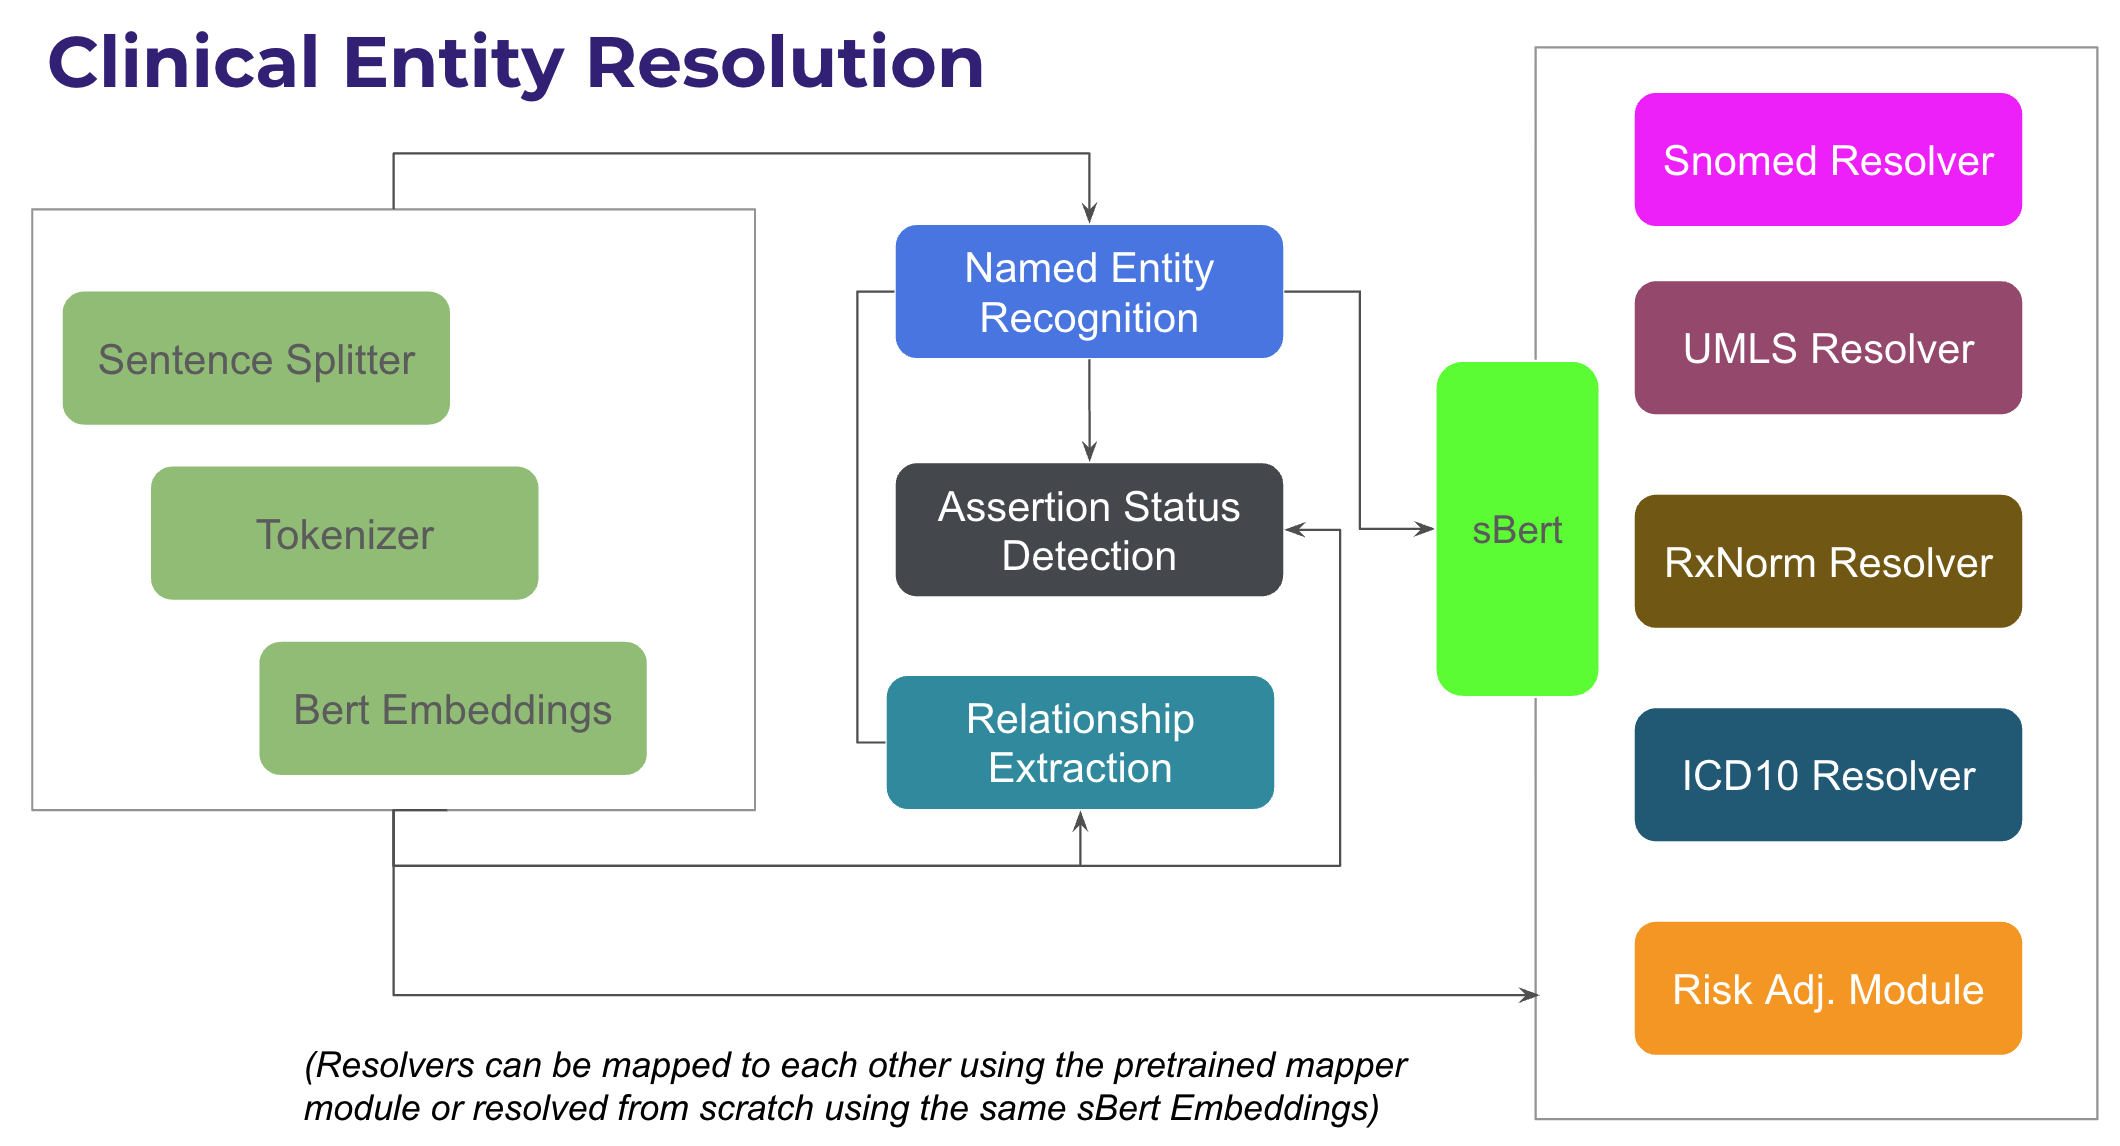

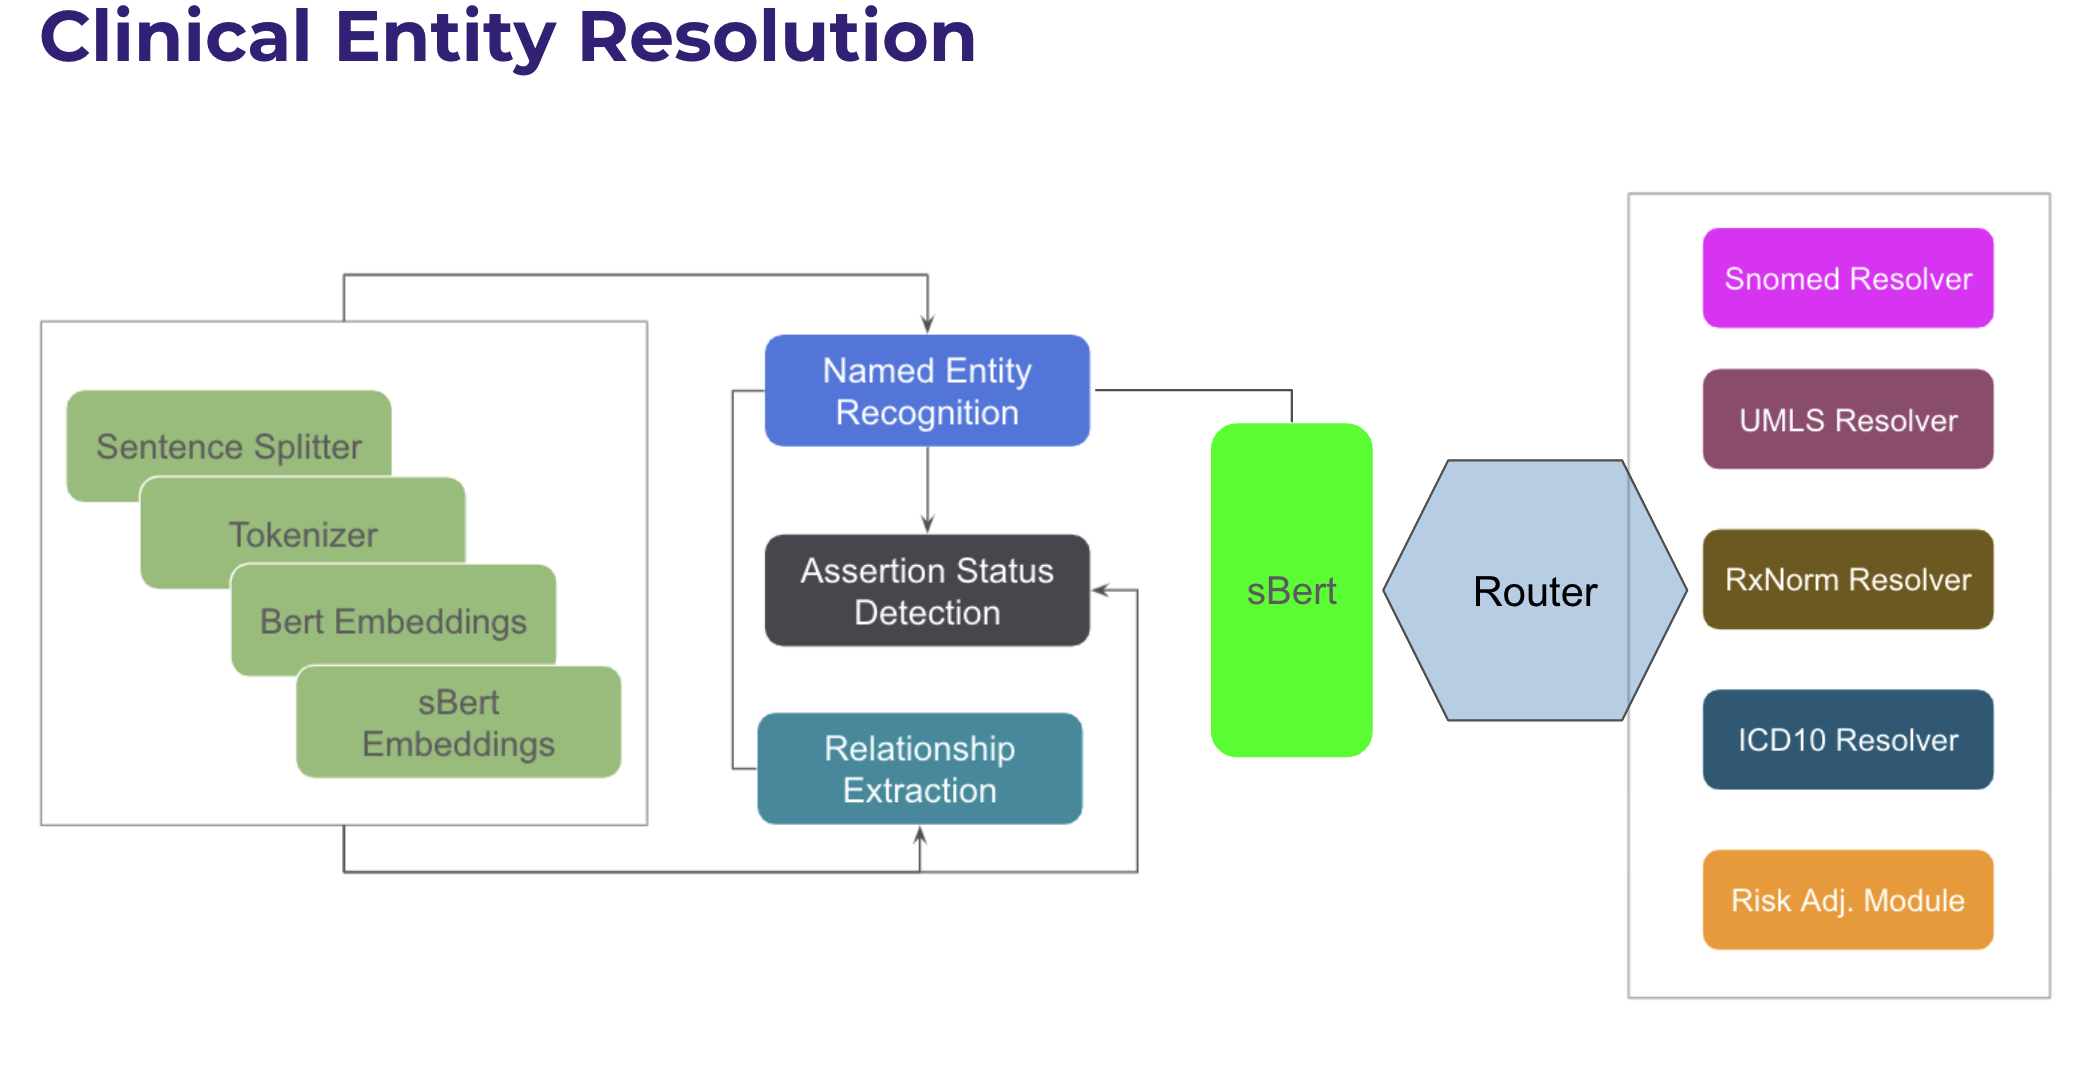

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We create a new pipeline that from each of these problems will try to assign an resolution on the content, the sentence embeddings and some pretrained models for resolver annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverterInternal (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their resolutions.

`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexing of the first (for begin) and last (for end) tokens


<center><b>MODEL LIST</b>

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [biolordresolve_avg_rxnorm_augmented](https://nlp.johnsnowlabs.com/2024/05/07/biolordresolve_avg_rxnorm_augmented_en.html)  | 2| [biolordresolve_avg_rxnorm_augmented_v2](https://nlp.johnsnowlabs.com/2024/08/20/biolordresolve_avg_rxnorm_augmented_v2_en.html)  | 3| [biolordresolve_cpt_procedures_measurements_augmented](https://nlp.johnsnowlabs.com/2024/05/08/biolordresolve_cpt_procedures_measurements_augmented_en.html)  | 4| [biolordresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2024/09/12/biolordresolve_icd10cm_augmented_billable_hcc_en.html)  |
| 5| [biolordresolve_loinc_augmented](https://nlp.johnsnowlabs.com/2024/10/08/biolordresolve_loinc_augmented_en.html)  | 6| [biolordresolve_rxnorm_augmented](https://nlp.johnsnowlabs.com/2024/05/06/biolordresolve_rxnorm_augmented_en.html)  | 7| [biolordresolve_rxnorm_augmented_v2](https://nlp.johnsnowlabs.com/2024/08/19/biolordresolve_rxnorm_augmented_v2_en.html)  | 8| [biolordresolve_snomed_findings_aux_concepts](https://nlp.johnsnowlabs.com/2024/05/07/biolordresolve_snomed_findings_aux_concepts_en.html)  |
| 9| [biolordresolve_umls_general_concepts](https://nlp.johnsnowlabs.com/2024/05/06/biolordresolve_umls_general_concepts_en.html)  | 10| [medembed_base_rxnorm_augmented](https://nlp.johnsnowlabs.com/2024/11/19/medembed_base_rxnorm_augmented_en.html)  | 11| [medmebed_large_rxnorm_augmented](https://nlp.johnsnowlabs.com/2024/11/19/medmebed_large_rxnorm_augmented_en.html)  | 12| [mpnetresolve_icd10_cms_hcc_2024_midyear](https://nlp.johnsnowlabs.com/2024/07/27/mpnetresolve_icd10_cms_hcc_2024_midyear_en.html)  |
| 13| [sbertresolve_hcc_augmented](https://nlp.johnsnowlabs.com/2024/09/04/sbertresolve_hcc_augmented_en.html)  | 14| [sbertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2024/09/03/sbertresolve_icd10cm_augmented_en.html)  | 15| [sbertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2024/09/04/sbertresolve_icd10cm_augmented_billable_hcc_en.html)  | 16| [sbertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_slim_billable_hcc_en.html)  |
| 17| [sbertresolve_icd10cm_slim_billable_hcc_med](https://nlp.johnsnowlabs.com/2021/05/25/sbertresolve_icd10cm_slim_billable_hcc_med_en.html)  | 18| [sbertresolve_jsl_rxnorm_augmented_med](https://nlp.johnsnowlabs.com/2021/12/28/sbertresolve_jsl_rxnorm_augmented_med_en.html)  | 19| [sbertresolve_ner_model_finder](https://nlp.johnsnowlabs.com/2022/09/05/sbertresolve_ner_model_finder_en.html)  | 20| [sbertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_rxnorm_disposition_en.html)  |
| 21| [sbertresolve_snomed_bodyStructure_med](https://nlp.johnsnowlabs.com/2021/06/15/sbertresolve_snomed_bodyStructure_med_en.html)  | 22| [sbertresolve_snomed_conditions](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_snomed_conditions_en.html)  | 23| [sbiobertresolve_HPO](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_HPO_en.html)  | 24| [sbiobertresolve_atc](https://nlp.johnsnowlabs.com/2022/03/01/sbiobertresolve_atc_en_2_4.html)  |
| 25| [sbiobertresolve_clinical_abbreviation_acronym](https://nlp.johnsnowlabs.com/2022/01/03/sbiobertresolve_clinical_abbreviation_acronym_en.html)  | 26| [sbiobertresolve_clinical_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/15/sbiobertresolve_clinical_snomed_procedures_measurements_en.html)  | 27| [sbiobertresolve_cpt](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_cpt_en.html)  | 28| [sbiobertresolve_cpt_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_augmented_en.html)  |
| 29| [sbiobertresolve_cpt_procedures_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_procedures_augmented_en.html)  | 30| [sbiobertresolve_cpt_procedures_measurements_augmented](https://nlp.johnsnowlabs.com/2022/05/10/sbiobertresolve_cpt_procedures_measurements_augmented_en_3_0.html)  | 31| [sbiobertresolve_cvx](https://nlp.johnsnowlabs.com/2022/10/12/sbiobertresolve_cvx_en.html)  | 32| [sbiobertresolve_hcc_augmented](https://nlp.johnsnowlabs.com/2024/09/02/sbiobertresolve_hcc_augmented_en.html)  |
| 33| [sbiobertresolve_hcpcs](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html)  | 34| [sbiobertresolve_hgnc](https://nlp.johnsnowlabs.com/2023/03/26/sbiobertresolve_hgnc_en.html)  | 35| [sbiobertresolve_icd10cm](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10cm_en.html)  | 36| [sbiobertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2021/10/31/sbiobertresolve_icd10cm_augmented_en.html)  |
| 37| [sbiobertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html)  | 38| [sbiobertresolve_icd10cm_generalised](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html)  | 39| [sbiobertresolve_icd10cm_generalised_augmented](https://nlp.johnsnowlabs.com/2024/09/05/sbiobertresolve_icd10cm_generalised_augmented_en.html)  | 40| [sbiobertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_icd10cm_slim_billable_hcc_en.html)  |
| 41| [sbiobertresolve_icd10cm_slim_normalized](https://nlp.johnsnowlabs.com/2021/05/17/sbiobertresolve_icd10cm_slim_normalized_en.html)  | 42| [sbiobertresolve_icd10pcs](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html)  | 43| [sbiobertresolve_icd10pcs_augmented](https://nlp.johnsnowlabs.com/2022/10/28/sbiobertresolve_icd10pcs_augmented_en.html)  | 44| [sbiobertresolve_icd9](https://nlp.johnsnowlabs.com/2022/09/30/sbiobertresolve_icd9_en.html)  |
| 45| [sbiobertresolve_icdo](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icdo_en.html)  | 46| [sbiobertresolve_icdo_augmented](https://nlp.johnsnowlabs.com/2021/06/22/sbiobertresolve_icdo_augmented_en.html)  | 47| [sbiobertresolve_icdo_base](https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html)  | 48| [sbiobertresolve_jsl_rxnorm_augmented](https://nlp.johnsnowlabs.com/2021/12/27/sbiobertresolve_jsl_rxnorm_augmented_en.html)  |
| 49| [sbiobertresolve_loinc](https://nlp.johnsnowlabs.com/2024/10/07/sbiobertresolve_loinc_en.html)  | 50| [sbiobertresolve_loinc_augmented](https://nlp.johnsnowlabs.com/2024/10/07/sbiobertresolve_loinc_augmented_en.html)  | 51| [sbiobertresolve_loinc_cased](https://nlp.johnsnowlabs.com/2021/12/24/sbiobertresolve_loinc_cased_en.html)  | 52| [sbiobertresolve_loinc_numeric](https://nlp.johnsnowlabs.com/2023/08/01/sbiobertresolve_loinc_numeric_en.html)  |
| 53| [sbiobertresolve_loinc_numeric_augmented](https://nlp.johnsnowlabs.com/2024/10/07/sbiobertresolve_loinc_numeric_augmented_en.html)  | 54| [sbiobertresolve_meddra_lowest_level_term](https://nlp.johnsnowlabs.com/2024/09/02/sbiobertresolve_meddra_lowest_level_term_en.html)  | 55| [sbiobertresolve_meddra_preferred_term](https://nlp.johnsnowlabs.com/2024/09/02/sbiobertresolve_meddra_preferred_term_en.html)  | 56| [sbiobertresolve_mesh](https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html)  |
| 57| [sbiobertresolve_ncit](https://nlp.johnsnowlabs.com/2023/03/26/sbiobertresolve_ncit_en.html)  | 58| [sbiobertresolve_ndc](https://nlp.johnsnowlabs.com/2024/09/12/sbiobertresolve_ndc_en.html)  | 59| [sbiobertresolve_rxcui](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html)  | 60| [sbiobertresolve_rxnorm](https://nlp.johnsnowlabs.com/2021/10/10/sbiobertresolve_rxnorm_en.html)  |
| 61| [sbiobertresolve_rxnorm_action_treatment](https://nlp.johnsnowlabs.com/2022/04/25/sbiobertresolve_rxnorm_action_treatment_en_2_4.html)  | 62| [sbiobertresolve_rxnorm_augmented](https://nlp.johnsnowlabs.com/2024/06/18/sbiobertresolve_rxnorm_augmented_en.html)  | 63| [sbiobertresolve_rxnorm_augmented_cased](https://nlp.johnsnowlabs.com/2021/12/28/sbiobertresolve_rxnorm_augmented_cased_en.html)  | 64| [sbiobertresolve_rxnorm_augmented_re](https://nlp.johnsnowlabs.com/2022/02/09/sbiobertresolve_rxnorm_augmented_re_en.html)  |
| 65| [sbiobertresolve_rxnorm_augmented_v2](https://nlp.johnsnowlabs.com/2024/08/14/sbiobertresolve_rxnorm_augmented_v2_en.html)  | 66| [sbiobertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html)  | 67| [sbiobertresolve_rxnorm_ndc](https://nlp.johnsnowlabs.com/2021/10/05/sbiobertresolve_rxnorm_ndc_en.html)  | 68| [sbiobertresolve_rxnorm_nih](https://nlp.johnsnowlabs.com/2023/02/22/sbiobertresolve_rxnorm_nih_en.html)  |
| 69| [sbiobertresolve_snomed_auxConcepts](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_en.html)  | 70| [sbiobertresolve_snomed_auxConcepts_int](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_int_en.html)  | 71| [sbiobertresolve_snomed_bodyStructure](https://nlp.johnsnowlabs.com/2024/03/04/sbiobertresolve_snomed_bodyStructure_en.html)  | 72| [sbiobertresolve_snomed_conditions](https://nlp.johnsnowlabs.com/2024/03/04/sbiobertresolve_snomed_conditions_en.html)  |
| 73| [sbiobertresolve_snomed_drug](https://nlp.johnsnowlabs.com/2024/03/06/sbiobertresolve_snomed_drug_en.html)  | 74| [sbiobertresolve_snomed_findings](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_findings_en.html)  | 75| [sbiobertresolve_snomed_findings_auxConcepts](https://nlp.johnsnowlabs.com/2024/02/14/sbiobertresolve_snomed_findings_auxConcepts_en.html)  | 76| [sbiobertresolve_snomed_findings_aux_concepts](https://nlp.johnsnowlabs.com/2024/03/06/sbiobertresolve_snomed_findings_aux_concepts_en.html)  |
| 77| [sbiobertresolve_snomed_findings_int](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_findings_int_en.html)  | 78| [sbiobertresolve_snomed_no_class](https://nlp.johnsnowlabs.com/2024/03/05/sbiobertresolve_snomed_no_class_en.html)  | 79| [sbiobertresolve_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html)  | 80| [sbiobertresolve_snomed_veterinary](https://nlp.johnsnowlabs.com/2024/06/10/sbiobertresolve_snomed_veterinary_en.html)  |
| 81| [sbiobertresolve_snomed_veterinary_wip](https://nlp.johnsnowlabs.com/2024/05/06/sbiobertresolve_snomed_veterinary_wip_en.html)  | 82| [sbiobertresolve_umls_clinical_drugs](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html)  | 83| [sbiobertresolve_umls_disease_syndrome](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html)  | 84| [sbiobertresolve_umls_drug_substance](https://nlp.johnsnowlabs.com/2024/05/05/sbiobertresolve_umls_drug_substance_en.html)  |
| 85| [sbiobertresolve_umls_findings](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_findings_en.html)  | 86| [sbiobertresolve_umls_general_concepts](https://nlp.johnsnowlabs.com/2024/05/05/sbiobertresolve_umls_general_concepts_en.html)  | 87| [sbiobertresolve_umls_major_concepts](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html)  | 88| [sbluebertresolve_loinc](https://nlp.johnsnowlabs.com/2021/04/29/sbluebertresolve_loinc_en.html)  |
| 89| [sbluebertresolve_loinc_uncased](https://nlp.johnsnowlabs.com/2022/01/18/sbluebertresolve_loinc_uncased_en.html)  | 90| [sbluebertresolve_rxnorm_augmented_uncased](https://nlp.johnsnowlabs.com/2021/12/28/sbluebertresolve_rxnorm_augmented_uncased_en.html)  | 91| []()| 92| []()|






<br>
<br>

<b>PRETRAINED PIPELINE LIST</b>

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [hcc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hcc_resolver_pipeline_en.html)  | 2| [hcpcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hcpcs_resolver_pipeline_en.html)  | 3| [hgnc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hgnc_resolver_pipeline_en.html)  | 4| [hpo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/18/hpo_resolver_pipeline_en.html)  |
| 5| [icd10cm_generalised_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/icd10cm_generalised_resolver_pipeline_en.html)  | 6| [icd10cm_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/11/02/icd10cm_resolver_pipeline_en.html)  | 7| [icd10cm_rxnorm_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/07/icd10cm_rxnorm_resolver_pipeline_en.html)  | 8| [icd10gm_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/07/01/icd10gm_resolver_pipeline_de.html)  |
| 9| [icd10pcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icd10pcs_resolver_pipeline_en.html)  | 10| [icd9_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/30/icd9_resolver_pipeline_en.html)  | 11| [icdo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icdo_resolver_pipeline_en.html)  | 12| [loinc_numeric_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/loinc_numeric_resolver_pipeline_en.html)  |
| 13| [loinc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/loinc_resolver_pipeline_en.html)  | 14| [meddra_llt_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/26/meddra_llt_resolver_pipeline_en.html)  | 15| [meddra_pt_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/26/meddra_pt_resolver_pipeline_en.html)  | 16| [medication_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_pipeline_en.html)  |
| 17| [medication_resolver_transform_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_transform_pipeline_en.html)  | 18| [mesh_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/mesh_resolver_pipeline_en.html)  | 19| [ncit_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/01/ncit_resolver_pipeline_en.html)  | 20| [ndc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ndc_resolver_pipeline_en.html)  |
| 21| [rxcui_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/01/rxcui_resolver_pipeline_en.html)  | 22| [rxnorm_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/rxnorm_multi_mapper_pipeline_en.html)  | 23| [rxnorm_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/rxnorm_resolver_pipeline_en.html)  | 24| [snomed_auxConcepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/12/snomed_auxConcepts_resolver_pipeline_en.html)  |
| 25| [snomed_body_structure_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/05/snomed_body_structure_resolver_pipeline_en.html)  | 26| [snomed_conditions_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/11/snomed_conditions_resolver_pipeline_en.html)  | 27| [snomed_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/11/snomed_drug_resolver_pipeline_en.html)  | 28| [snomed_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/03/snomed_findings_resolver_pipeline_en.html)  |
| 29| [snomed_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/snomed_multi_mapper_pipeline_en.html)  | 30| [snomed_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/31/snomed_procedures_measurements_resolver_pipeline_en.html)  | 31| [snomed_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/11/snomed_resolver_pipeline_en.html)  | 32| [snomed_term_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/22/snomed_term_resolver_pipeline_en.html)  |
| 33| [umls_clinical_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/03/30/umls_clinical_findings_resolver_pipeline_en.html)  | 34| [umls_disease_syndrome_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/03/30/umls_disease_syndrome_resolver_pipeline_en.html)  | 35| [umls_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/03/29/umls_drug_resolver_pipeline_en.html)  | 36| [umls_drug_substance_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/03/30/umls_drug_substance_resolver_pipeline_en.html)  |
| 37| [umls_major_concepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/03/30/umls_major_concepts_resolver_pipeline_en.html)






</center>

You can find all resolver models and more on [Models Hub](https://nlp.johnsnowlabs.com/models?task=Entity+Resolution&edition=Spark+NLP+for+Healthcare) page.lution&edition=Spark+NLP+for+Healthcare) page.

## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

### Helper Functions
Writing Generic Function For Getting the Codes and Relation Pairs

In [2]:
# returns LP resolution results

import pandas as pd
pd.set_option('display.max_colwidth', 0)

def get_codes (lp, text, vocab='icd10cm_code', aux=False, hcc=False):
    """
    Extracts codes from text using a given LightPipeline model and returns the results in pandas DataFrame format.

    Parameters:
    - lp (LightPipeline): The LightPipeline model to be used for annotation.
    - text (str): The text from which codes are to be extracted.
    - vocab (str, optional): The vocabulary to use for code extraction. Default is 'icd10cm_code'.
    - aux (bool, optional): Whether to include auxiliary information. Default is False.
    - hcc (bool, optional): Whether to extract hierarchical condition category (HCC) related information in the ICD-10-CM model results. Default is False.

    Returns:
    - pandas.DataFrame: A DataFrame containing extracted codes along with their metadata.
                         Columns include 'chunks', 'begin', 'end', 'code', 'resolutions', 'all_codes', 'all_resolutions', 'all_k_aux_labels', 'all_distances'.
                         If 'hcc' is True, additional columns 'billable', 'hcc_status', and 'hcc_code' will be included.
    """

    full_light_result = lp.fullAnnotate(text)

    chunks = [chunk.result for chunk in full_light_result[0]['ner_chunk']]
    begin = [chunk.begin for chunk in full_light_result[0]['ner_chunk']]
    end = [chunk.end for chunk in full_light_result[0]['ner_chunk']]
    codes = [code.result for code in full_light_result[0][vocab]]
    resolutions = [code.metadata['resolved_text'].split(':::') for code in full_light_result[0][vocab]]
    all_codes = [code.metadata['all_k_results'].split(':::') for code in full_light_result[0][vocab]]
    all_resolutions = [code.metadata['all_k_resolutions'].split(':::') for code in full_light_result[0][vocab]]
    all_distances = [code.metadata['all_k_distances'].split(':::') for code in full_light_result[0][vocab]]
    all_cosines = [code.metadata['all_k_cosine_distances'].split(':::') for code in full_light_result[0][vocab]]
    all_k_aux_labels = [
        code.metadata.get('all_k_aux_labels', '').split(':::') if aux else []
        for code in full_light_result[0][vocab]
    ]

    df = pd.DataFrame({
        'chunks': chunks,
        'begin': begin,
        'end': end,
        'code': codes,
        'resolution': resolutions,
        'all_codes': all_codes,
        'all_resolutions': all_resolutions,
        'all_k_aux_labels': all_k_aux_labels,
        'all_cos_distances': all_cosines
    })

    if not aux:
        df = df.drop(['all_k_aux_labels'], axis=1)

    if hcc:

        df['billable'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[0] for i in x])
        df['hcc_status'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[1] for i in x])
        df['hcc_code'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[2] for i in x])
        df = df.drop(['all_k_aux_labels'], axis=1)

    return df

In [3]:
def get_codes_from_df(result_df, chunk, output_col, aux= False):

    """
    Extracts codes from a Spark DataFrame and returns the results in pandas DataFrame format.

    Parameters:
    - result_df (DataFrame): The Spark DataFrame containing the results.
    - chunk (str): The column name in the DataFrame representing the NER chunk output.
    - output_col (str): The column name in the DataFrame representing the resolver model output.
    - aux (bool, optional): Whether to include auxiliary information. Default is False.

    Returns:
    - pandas.DataFrame: A DataFrame containing extracted codes along with their metadata.
                         Columns include 'sent_id', 'ner_chunk', 'entity', 'output_col', 'resolution',
                         'all_codes', 'all_resolutions', and 'aux_list' (if aux is True).
    """

    if aux:

        df = result_df.select(F.explode(F.arrays_zip(result_df[chunk].result,
                                                    result_df[chunk].metadata,
                                                    result_df[output_col].result,
                                                    result_df[output_col].metadata)).alias("cols")) \
                      .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                              F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['entity']").alias("entity"),
                              F.expr("cols['2']").alias(f"{output_col}"),
                              F.expr("cols['3']['resolved_text']").alias("resolution"),
                              F.expr("cols['3']['all_k_results']").alias("all_codes"),
                              F.expr("cols['3']['all_k_resolutions']").alias("all_resolutions"),
                              F.expr("cols['3']['all_k_aux_labels']").alias("aux_list")).toPandas()



        codes = []
        resolutions = []
        aux_list = []

        for code, resolution, aux_info in zip(df['all_codes'], df['all_resolutions'], df['aux_list']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))
            aux_list.append(aux_info.split(":::"))

        df['all_codes'] = codes
        df['all_resolutions'] = resolutions
        df['aux_list'] = aux_list

    else:

        df = result_df.select(F.explode(F.arrays_zip(result_df[chunk].result,
                                                     result_df[chunk].metadata,
                                                     result_df[output_col].result,
                                                     result_df[output_col].metadata)).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"),
                                             F.expr("cols['2']").alias(f"{output_col}"),
                                             F.expr("cols['3']['resolved_text']").alias("resolutions"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("all_resolutions")).toPandas()

        codes = []
        resolutions = []

        for code, resolution in zip(df['all_codes'], df['all_resolutions']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))

        df['all_codes'] = codes
        df['all_resolutions'] = resolutions

    return df

In [4]:
# returns billable informations in distinct columns

def extract_billable(bil):

    billable = [b.split("||")[0] for b in bil]
    status = [b.split("||")[1] for b in bil]
    code = [b.split("||")[2] for b in bil]

    return (billable, status, code)

In [5]:
# returns relation pair dataframe

def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for rel in results[0][col]:
        rel_pairs.append((
          rel.metadata['entity1'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['confidence']
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1','entity1_begin','entity1_end','chunk1',
                                              'entity2','entity2_end','entity2_end','chunk2',
                                              'confidence'])

    # limit df columns to get entity and chunks with results only
    rel_df = rel_df.iloc[:,[0,3,4,7,8]]

    return rel_df

## Sentence Entity Resolver (RxNorm)

- RxNorm is a second vocabulary for prescription drugs. RxNorm provides a set of codes for clinical drugs, which are the combination of active ingredients, dose form, and strength of a drug. For example, the RxNorm code for ciprofloxacin 500 mg 24-hour extended-release tablet (the generic name for Cipro XR 500 mg) is RX10359383, regardless of brand or packaging.

- The goal of RxNorm is to allow computer systems to communicate drug-related information efficiently and unambiguously. Produced by the National Library of Medicine (NLM), RxNorm is available for distribution in both Metathesaurus Relation (MR) and Rich Release Format (RRF) tables. Currently there are no RxNorm names available for drugs with more than four active ingredients, those that are sold over the counter (OTC) or those that are international, due to the lack of appropriate information available about such drugs. 


<img src="https://www.nlm.nih.gov/research/umls/rxnorm/RxNorm_Drug_Relationships.png" width="750" alt="RxNorm Overview">

**Pretrained Models**

- `sbiobertresolve_rxnorm`
- `demo_sbiobertresolve_rxnorm`
- `sbiobertresolve_rxnorm_dispo`
- `sbiobertresolve_rxnorm_disposition`
- `sbertresolve_rxnorm_disposition`
- `sbiobertresolve_rxnorm_ndc`
- `sbiobertresolve_rxnorm_augmented`
- `sbiobertresolve_rxnorm_augmented_re`

In [7]:
documentAssembler = nlp.DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")\
      .setCaseSensitive(False)
    
rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("rxnorm_code")\
      .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = nlp.PipelineModel(
      stages = [
          documentAssembler,
          sbert_embedder,
          rxnorm_resolver])

rxnorm_lp = nlp.LightPipeline(rxnorm_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
Download done! Loading the resource.
[ — ]

[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
sbiobertresolve_rxnorm_augmented download started this may take some time.
Approximate size to download 1.1 GB
Download done! Loading the resource.



OK!]

In [8]:
text = 'metformin 100 mg'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 26.8 ms, sys: 3.29 ms, total: 30.1 ms
Wall time: 1.14 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,metformin 100 mg,0,15,861024,[metformin hydrochloride 100 mg/ml [metformin hydrochloride 100 mg/ml]],"[861024, 334738, 332848, 861026, 333262, 429178, 103910, 429408, 1744000, 401938, 1726496, 316350, 213092, 858858, 336846, 208389, 316844, 1946837, 433322, 882531, 856606, 1307626, 437723, 385601, 315677]","[metformin hydrochloride 100 mg/ml [metformin hydrochloride 100 mg/ml], fenofibrate 100 mg [fenofibrate 100 mg], ciprofibrate 100 mg [ciprofibrate 100 mg], metformin hydrochloride 100 mg/ml [riomet] [metformin hydrochloride 100 mg/ml [riomet]], rutin 100 mg [rutin 100 mg], fendiline 100 MG Oral Tablet, carbamazepine 100 MG Oral Tablet [Epimaz], perazine 100 MG Oral Tablet, emtricitabine 100 mg [emtricitabine 100 mg], miglustat 100 MG Oral Capsule, azacitidine 100 mg [azacitidine 100 mg], niacin 100 mg [niacin 100 mg], dolasetron 100 MG Oral Tablet [Anzemet], carnosine 100 mg [carnosine 100 mg], trimebutine 100 mg [trimebutine 100 mg], thioridazine 100 MG Oral Tablet [Mellaril], torsemide 100 mg [torsemide 100 mg], abemaciclib 100 mg [abemaciclib 100 mg], pyrantel 100 MG Chewable Tablet, clindamycin 100 MG [Cleocin], rimantadine hydrochloride 100 MG [Flumadine], bosutinib 100 MG [Bosulif], azintamide 100 mg [azintamide 100 mg], mebeverine 100 mg [mebeverine 100 mg], cimetidine 100 mg [cimetidine 100 mg]]","[0.0658, 0.0684, 0.0697, 0.0770, 0.0765, 0.0775, 0.0780, 0.0804, 0.0818, 0.0811, 0.0812, 0.0811, 0.0836, 0.0828, 0.0844, 0.0840, 0.0846, 0.0840, 0.0844, 0.0849, 0.0850, 0.0843, 0.0851, 0.0851, 0.0876]"


In [9]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 12 ms, sys: 12.3 ms, total: 24.3 ms
Wall time: 1 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,aspirin 10 meq/ 5 ml oral sol,0,28,979446,[alupent 10 mg per 5 ml oral solution [metaproterenol sulfate 2 mg/ml oral solution [alupent]]],"[979446, 996740, 1091135, 991082, 997398, 636574, 794979, 729048, 995241, 996742, 261342, 422031, 312036, 795097, 205247, 644304, 251102, 208820, 1117402, 246529, 544468, 1313296, 2536066]","[alupent 10 mg per 5 ml oral solution [metaproterenol sulfate 2 mg/ml oral solution [alupent]], memantine hcl 10 mg per 5 ml oral solution [memantine hydrochloride 2 mg/ml oral solution], methylin 10 mg per 5 ml oral solution [methylphenidate hydrochloride 2 mg/ml oral solution [methylin]], dicyclomine hcl 10 mg per 5 ml oral solution [dicyclomine hydrochloride 2 mg/ml oral solution], codeine phosphate 10 mg per 5 ml oral solution [codeine phosphate 2 mg/ml oral solution], guaifenesin 10 mg/ml oral solution [guaifenesin 10 mg/ml oral solution], prednisolone 10 mg per 5 ml oral solution [prednisolone 2 mg/ml oral solution], pseudoephedrine tannate 10 mg/ml oral suspension [pseudoephedrine tannate 10 mg/ml oral suspension], hydroxyzine hydrochloride 2 MG/ML Oral Solution, namenda 10 mg per 5 ml oral solution [memantine hydrochloride 2 mg/ml oral solution [namenda]], celexa 10 mg per 5 ml oral solution [citalopram 2 mg/ml oral solution [celexa]], silymarin 10 mg/ml oral suspension [silymarin 10 mg/ml oral suspension], nortriptyline hcl 10 mg per 5 ml oral solution [nortriptyline 2 mg/ml oral solution], millipred 10 mg per 5 ml (as prednisolone sodium phosphate 13.4 mg per 5 ml) oral solution [prednisolone 2 mg/ml oral solution [millipred]], niacin 10 mg/ml oral solution [niacin 10 mg/ml oral solution], soltamox 10 mg per 5 ml oral solution [tamoxifen 2 mg/ml oral solution [soltamox]], nimesulide 10 mg/ml oral suspension [nimesulide 10 mg/ml oral suspension], trifluoperazine 10 MG/ML Oral Solution [Stelazine], guaifenesin 10 MG/ML Oral Solution [Liqufruta], midodrine 10 mg/ml oral solution [midodrine 10 mg/ml oral solution], hypromellose 10 mg/ml oral solution [hypromellose 10 mg/ml oral solution], guaifenesin 10 MG/ML / hydrocodone bitartrate 0.5 MG/ML / phenylephrine hydrochloride 1.5 MG/ML Oral Solution [Quala HC], ezetimibe 10 MG / rosuvastatin 5 MG Oral Tablet [Roszet]]","[0.0809, 0.0859, 0.0881, 0.0919, 0.0891, 0.0927, 0.0922, 0.0940, 0.0925, 0.0917, 0.0926, 0.0932, 0.0971, 0.0971, 0.0960, 0.0962, 0.0970, 0.0976, 0.0963, 0.0980, 0.1010, 0.0987, 0.0987]"


### RxNorm with DrugNormalizer

In [10]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk_v0")

drug_normalizer = medical.DrugNormalizer() \
    .setInputCols("ner_chunk_v0") \
    .setOutputCol("ner_chunk") \
    .setPolicy('all')

rxnorm_pipelineModel2 = nlp.PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = nlp.LightPipeline(rxnorm_pipelineModel2)

In [11]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp2, text, vocab='rxnorm_code')

CPU times: user 27.2 ms, sys: 2.29 ms, total: 29.5 ms
Wall time: 1.04 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,aspirin 2 meq/ml oral solution,0,29,688214,[aspirin 2.5 mg/ml oral solution [aspirin 2.5 mg/ml oral solution]],"[688214, 342917, 755937, 756028, 979446, 755332, 545588, 1091135, 246229, 104692, 755920, 261342, 756064, 756078, 2381144, 1115998, 1092456, 248847, 1094188, 250944, 108870, 995243, 421803, 755276]","[aspirin 2.5 mg/ml oral solution [aspirin 2.5 mg/ml oral solution], aspirin 2.2 mg/ml [aspirin 2.2 mg/ml], periciazine 2 mg/ml oral solution [periciazine 2 mg/ml oral solution], fenspiride 2 mg/ml oral solution [fenspiride 2 mg/ml oral solution], metaproterenol sulfate 2 MG/ML Oral Solution [Alupent], merbentyl 2 mg/ml oral solution [dicyclomine hydrochloride 2 mg/ml oral solution [merbentyl]], orostat 2 mg/ml oral solution [racepinephrine 2 mg/ml oral solution [orostat]], methylphenidate hydrochloride 2 MG/ML Oral Solution [Methylin], thioridazine 2 mg/ml oral solution [thioridazine 2 mg/ml oral solution], temazepam 2 MG/ML Oral Solution [Euhypnos], butamirate 2 mg/ml oral solution [butamirate 2 mg/ml oral solution], celexa 2 mg/ml oral solution [citalopram 2 mg/ml oral solution [celexa]], oxeladin 2 mg/ml oral solution [oxeladin 2 mg/ml oral solution], pipazethate 2 mg/ml oral solution [pipazethate 2 mg/ml oral solution], fintepla 2.2 mg/ml oral solution [fenfluramine 2.2 mg/ml oral solution [fintepla]], ephedrine sulfate 2.2 mg/ml oral solution [ephedrine sulfate 2.2 mg/ml oral solution], diphenhydramine hydrochloride 2.5 MG/ML Oral Solution [Diphenhist], homatropine 2 mg/ml oral solution [homatropine 2 mg/ml oral solution], diphedryl 2.5 mg/ml oral solution [diphenhydramine hydrochloride 2.5 mg/ml oral solution [diphedryl]], piracetam 2 mg/ml oral solution [piracetam 2 mg/ml oral solution], theophylline 2 mg/ml oral solution [theophylline 2 mg/ml oral solution], atarax 2 mg/ml oral solution [hydroxyzine hydrochloride 2 mg/ml oral solution [atarax]], codeine 2 mg/ml oral suspension [codeine 2 mg/ml oral suspension], eldepryl 2 mg/ml oral solution [selegiline hydrochloride 2 mg/ml oral solution [eldepryl]]]","[0.0347, 0.0566, 0.0947, 0.1040, 0.1009, 0.1075, 0.1081, 0.1097, 0.1155, 0.1137, 0.1149, 0.1123, 0.1154, 0.1178, 0.1175, 0.1196, 0.1212, 0.1211, 0.1242, 0.1196, 0.1236, 0.1214, 0.1175, 0.1249]"


### Clinical Chunk Mapper Models

We can use sparknlp's Chunk Mapping feature to map clinical entities with their correspondings based on pre-defined dictionary. We have pretrained chunk mapping models that can be used through ChunkMapperModel() annotator, also, it is possible to create your own pretrained Chunk Mapper models by ChunkMapperApproach() annotator.

You can check [Healthcare Code Mapping Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/11.1.Healthcare_Code_Mapping.ipynb) for the examples of pretrained mapper pipelines.


Lets show an example of `rxnorm_mapper` model that maps entities with their corresponding RxNorm codes.

In [12]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

chunkerMapper = medical.ChunkMapperModel.pretrained("rxnorm_mapper", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("rxnorm")\
    .setRels(["rxnorm_code"])


mapper_pipeline = nlp.Pipeline().setStages([document_assembler, chunkerMapper])
mapper_model = mapper_pipeline.fit(spark.createDataFrame([['']]).toDF('text'))

mapper_lp = nlp.LightPipeline(mapper_model)

rxnorm_mapper download started this may take some time.
rxnorm_mapper download started this may take some time.
Approximate size to download 10 MB
Download done! Loading the resource.


[Stage 8:============================================>              (3 + 1) / 4]

[ — ]


OK!]

In [13]:
%time mapper_lp.fullAnnotate("metformin")

CPU times: user 14.6 ms, sys: 3.3 ms, total: 17.9 ms
Wall time: 137 ms


[{'ner_chunk': [Annotation(document, 0, 8, metformin, {}, [])],
  'rxnorm': [Annotation(labeled_dependency, 0, 8, 6809, {'__trained__': 'metformin', 'relation': 'rxnorm_code', 'all_k_distances': '0.0:::0.0', '__distance_function__': 'levenshtein', 'all_k_resolutions': '6809:::', 'target_text': 'metformin', 'ops': '0.0', 'all_relations': '', 'resolved_text': '6809', 'distance': '0.0', '__relation_name__': 'rxnorm_code'}, [])]}]

### Drug Spell Checker

In [13]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols("document")\
    .setOutputCol("token")

spell = nlp.NorvigSweetingModel.pretrained("spellcheck_drug_norvig", "en", "clinical/models")\
    .setInputCols("token")\
    .setOutputCol("corrected_token")\

pipeline = nlp.Pipeline(stages = [documentAssembler,
                              tokenizer, 
                              spell])

model = pipeline.fit(spark.createDataFrame([['']]).toDF('text')) 
lp = nlp.LightPipeline(model)

spellcheck_drug_norvig download started this may take some time.
Approximate size to download 4.3 MB
spellcheck_drug_norvig download started this may take some time.
Approximate size to download 4.3 MB
Download done! Loading the resource.



OK!]

In [14]:
text = "You have to take Neutrcare and colfosinum and a bit of Fluorometholne & Ribotril"

corrected = lp.annotate(text)

print(" ".join(corrected['token']))
print(" ".join(corrected['corrected_token']))

You have to take Neutrcare and colfosinum and a bit of Fluorometholne & Ribotril
You have to take Neutracare and colfosinum and a bit of Fluorometholone & Rivotril


## Sentence Entity Resolver (ICD-10CM)

###  ICD10 background info

**ICD-10-CM vs. ICD-10-PCS**

- With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

- **The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

- ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

- ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

- ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

- When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

**ICD-10-CM breakdown**

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


**ICD-10-PCS breakdown**

- Will replace ICD-9-CM for hospital inpatient use only. 
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”
- 7 alphanumeric characters

- ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.

**Hierarchical Condition Category (HCC)**

- Hierarchical condition category (HCC) coding is a risk-adjustment model originally designed to estimate future health care costs for patients. The Centers for Medicare & Medicaid Services (CMS) HCC model was initiated in 2004 but is becoming increasingly prevalent as the environment shifts to value-based payment models.

- Hierarchical condition category relies on ICD-10 coding to assign risk scores to patients. Each HCC is mapped to an ICD-10 code. Along with demographic factors (such as age and gender), insurance companies use HCC coding to assign patients a risk adjustment factor (RAF) score. Using algorithms, insurances can use a patient’s RAF score to predict costs. For example, a patient with few serious health conditions could be expected to have average medical costs for a given time. However, a patient with multiple chronic conditions would be expected to have higher health care utilization and costs.

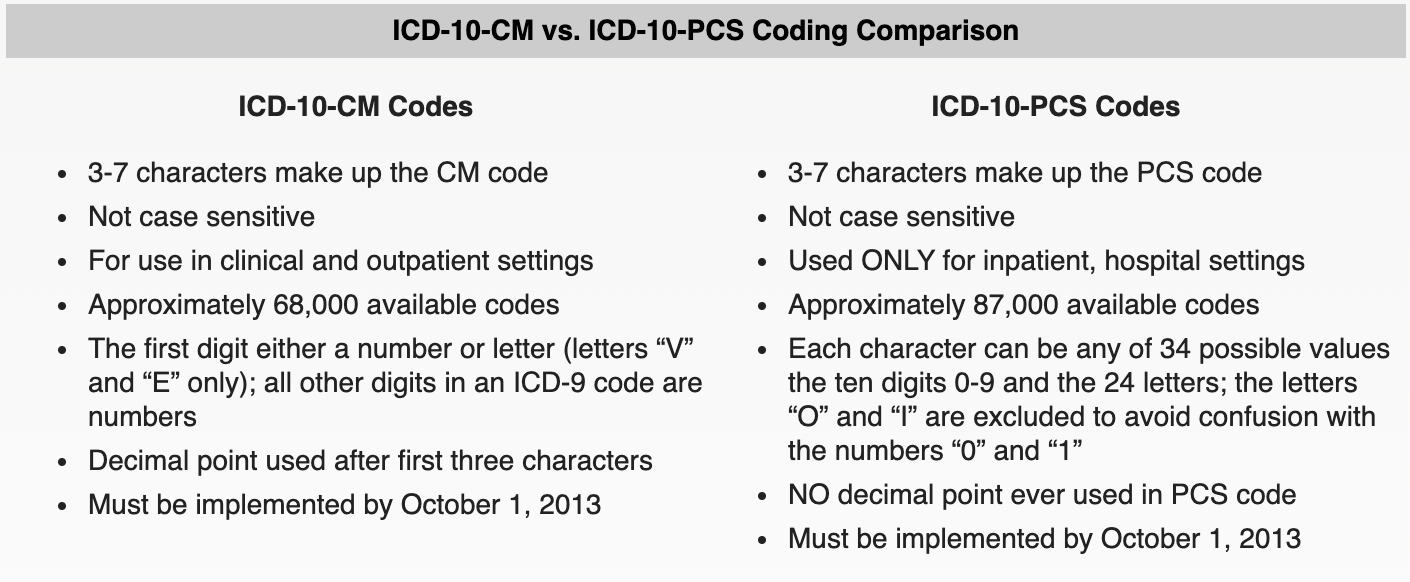

**Pretrained ICD-10 Models**

- `sbiobertresolve_icd10cm_augmented`
- `sbiobertresolve_icd10pcs`
- `sbiobertresolve_icd10cm_augmented_billable_hcc`
- `sbiobertresolve_icd10cm`
- `sbiobertresolve_icd10cm_slim_normalized`
- `sbiobertresolve_icd10cm_slim_billable_hcc`
- `sbertresolve_icd10cm_slim_billable_hcc_med`
- `sbiobertresolve_icd10cm_generalised`

### Creating ICD-10CM Pipeline

In [14]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")

# Named Entity Recognition for clinical concepts.
clinical_ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_converter_icd = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['PROBLEM'])\
    .setPreservePosition(False)

c2doc = nlp.Chunk2Doc()\
    .setInputCols("ner_chunk")\
    .setOutputCol("doc_ner_chunk") 

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")
    

# Build up the pipeline
resolver_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        c2doc,
        sbert_embedder,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")

model = resolver_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
Download done! Loading the resource.
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
ner_clinical download started this may take some time.
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size

**Create a SparkDataFrame with the content**

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [16]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness or guarding. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission.')

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [17]:
data_ner.show(truncate = 100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [17]:
icd10_result = model.transform(data_ner)

In [18]:
%time icd10_result.select("icd10cm_code.metadata").collect()[0][0][0]

[Stage 18:==================================================>       (7 + 1) / 8]

CPU times: user 9.32 ms, sys: 4.57 ms, total: 13.9 ms
Wall time: 18.2 s


{'all_k_aux_labels': '0||0||0:::0||0||0:::0||0||0:::1||0||0:::0||0||0:::0||0||0:::0||0||0:::0||0||0:::0||0||0',
 'sentence': '0',
 'resolved_text': 'gestational diabetes mellitus [gestational diabetes mellitus]',
 'target_text': 'gestational diabetes mellitus',
 'all_k_confidences': '0.9589:::0.0209:::0.0045:::0.0041:::0.0041:::0.0033:::0.0023:::0.0011:::0.0008',
 'distance': '0.0000',
 'confidence': '0.9589',
 'chunk': '0',
 'all_k_results': 'O24.4:::O24.41:::O24.43:::Z86.32:::Z87.5:::O24.31:::O24.11:::O24.1:::O24.81',
 'token': 'gestational diabetes mellitus',
 'all_k_distances': '0.0000:::3.8239:::5.3717:::5.4480:::5.4515:::5.6762:::6.0468:::6.7514:::7.0958',
 'all_k_resolutions': 'gestational diabetes mellitus [gestational diabetes mellitus]:::gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy]:::postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium]:::history of gestational diabetes mellitus [personal history of

In [24]:
%%time

res_pd = get_codes_from_df(icd10_result, 'ner_chunk', 'icd10cm_code', aux=True)
res_pd.head(10)

[Stage 21:==================================================>       (7 + 1) / 8]

CPU times: user 9.21 ms, sys: 8.93 ms, total: 18.1 ms
Wall time: 15.1 s


,sent_id,ner_chunk,entity,icd10cm_code,resolution,all_codes,all_resolutions,aux_list
0,0,gestational diabetes mellitus,PROBLEM,O24.4,gestational diabetes mellitus [gestational diabetes mellitus],"[O24.4, O24.41, O24.43, Z86.32, Z87.5, O24.31, O24.11, O24.1, O24.81]","[gestational diabetes mellitus [gestational diabetes mellitus], gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy], postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium], history of gestational diabetes mellitus [personal history of gestational diabetes], history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium], pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]]","[0||0||0, 0||0||0, 0||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O24.11,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]","[O24.11, E11.8, E11, E13.9, E11.9, E11.3, E11.44, Z86.3, Z86.39, E11.32, E11.43, E11.5]","[pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications], type 2 diabetes mellitus [type 2 diabetes mellitus], secondary diabetes mellitus [other specified diabetes mellitus without complications], diabetes mellitus type 2 [type 2 diabetes mellitus without complications], disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications], disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy], history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases], history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease], secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy], neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]]","[0||0||0, 1||1||18, 0||0||0, 1||1||19, 1||1||19, 0||0||0, 1||1||18, 0||0||0, 1||0||0, 0||0||0, 1||1||18, 0||0||0]"
2,0,an acute hepatitis,PROBLEM,B15,acute hepatitis a [acute hepatitis a],"[B15, K72.0, B17.9, B17.2, Z03.89, B15.9, K75.2, K71.2, B19.9, B16, K70.1, B16.9]","[acute hepatitis a [acute hepatitis a], acute hepatitis [acute and subacute hepatic failure], acute infectious hepatitis [acute viral hepatitis, unspecified], acute hepatitis e [acute hepatitis e], acute infectious hepatitis suspected [encounter for observation for other suspected diseases and conditions ruled out], acute type a viral hepatitis [hepatitis a without hepatic coma], acute focal hepatitis [nonspecific reactive hepatitis], toxic liver disease with acute hepatitis [toxic liver disease with acute hepatitis], fulminant hepatitis [unspecified viral hepatitis without hepatic coma], acute hepatitis b [acute hepatitis b], acute alcoholic hepatitis [alcoholic hepatitis], acute fulminating viral hepatitis [acute hepatitis b without delta-agent and without hepatic coma]]","[0||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 1||0||0]"
3,0,obesity,PROBLEM,E66.9,"obesity [obesity, unspecified]","[E66.9, E66.8, Z68.41, Q13.0, E66, E66

In [25]:
res_pd["billable"] = res_pd["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
res_pd["hcc_status"] = res_pd["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_pd["hcc_code"] = res_pd["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_pd.drop("aux_list", axis=1, inplace= True)

In [26]:
res_pd.head(15)

,sent_id,ner_chunk,entity,icd10cm_code,resolution,all_codes,all_resolutions,billable,hcc_status,hcc_code
0,0,gestational diabetes mellitus,PROBLEM,O24.4,gestational diabetes mellitus [gestational diabetes mellitus],"[O24.4, O24.41, O24.43, Z86.32, Z87.5, O24.31, O24.11, O24.1, O24.81]","[gestational diabetes mellitus [gestational diabetes mellitus], gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy], postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium], history of gestational diabetes mellitus [personal history of gestational diabetes], history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium], pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]]","[0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O24.11,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]","[O24.11, E11.8, E11, E13.9, E11.9, E11.3, E11.44, Z86.3, Z86.39, E11.32, E11.43, E11.5]","[pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications], type 2 diabetes mellitus [type 2 diabetes mellitus], secondary diabetes mellitus [other specified diabetes mellitus without complications], diabetes mellitus type 2 [type 2 diabetes mellitus without complications], disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications], disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy], history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases], history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease], secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy], neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]]","[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]","[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]","[0, 18, 0, 19, 19, 0, 18, 0, 0, 0, 18, 0]"
2,0,an acute hepatitis,PROBLEM,B15,acute hepatitis a [acute hepatitis a],"[B15, K72.0, B17.9, B17.2, Z03.89, B15.9, K75.2, K71.2, B19.9, B16, K70.1, B16.9]","[acute hepatitis a [acute hepatitis a], acute hepatitis [acute and subacute hepatic failure], acute infectious hepatitis [acute viral hepatitis, unspecified], acute hepatitis e [acute hepatitis e], acute infectious hepatitis suspected [encounter for observation for other suspected diseases and conditions ruled out], acute type a viral hepatitis [hepatitis a without hepatic coma], acute focal hepatitis [nonspecific reactive hepatitis], toxic liver disease with acute hepatitis [toxic liver disease with acute hepatitis], fulminant hepatitis [unspecified viral hepatitis without hepatic coma], acute hepatitis b [acute hepatitis b], acute alcoholic hepatitis [alcoholic hepatitis], acute fulminating viral hepatitis [acute hepatitis b without delta-agent and without hepatic coma]]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,0,obesity,PROBLEM,E66.9,"obesity [obesity, unspecified]","

Lets apply some HTML formating by using `sparknlp_display` library to see the results of the pipeline in a nicer layout:

In [23]:
from sparknlp_display import EntityResolverVisualizer

icd10_lp = nlp.LightPipeline(model)

light_result = icd10_lp.fullAnnotate(clinical_note)

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

### PipelineTracer and PipelineOutputParser
####  Automating Pipeline Tracing and Analysis with `PipelineTracer` to Help Return Structured JSONs from Pretrained Pipelines Via the `PipelineOuputParser` module

- `PipelineTracer` is a flexible class that tracks every stage of a pipeline. It provides detailed information about entities, assertions, de-identification, classification and relationships. This class also helps to build parser dictionaries to create a `PipelineOutputParser`. Some of the central functionality includes printing the pipeline schema, creating parser dictionaries, and retrieving possible assertions, relationships, and entities. Provide easy access to parser dictionaries and existing pipeline diagrams. Please see [PipelineTracer and PipelineOutputParser Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.4.PipelineTracer_and_PipelineOutputParser.ipynb) for more details

In [29]:
from sparknlp_jsl.pipeline_tracer import PipelineTracer

In [27]:
light_model = nlp.LightPipeline(model)

light_result = light_model.fullAnnotate(clinical_note)

In [30]:
pipeline_tracer = PipelineTracer(model)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "icd10cm_model_parser"})
column_maps

{'document_identifier': 'icd10cm_model_parser',
 'document_text': 'document',
 'entities': ['ner_chunk'],
 'assertions': [],
 'resolutions': [{'vocab': 'icd10cm_code',
   'resolver_column_name': 'icd10cm_code'}],
 'relations': [],
 'summaries': [],
 'deidentifications': [],
 'classifications': []}

In [31]:
pipeline_parser = medical.PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result)

result['result'][0]

{'document_identifier': 'icd10cm_model_parser',
 'document_id': 0,
 'document_text': ['A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness or guarding. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) 10%, and

In [32]:
resolutions_df = pd.DataFrame(result['result'][0]['resolutions'])
resolutions_df

,vocab,chunk_id,chunk,code,resolutions,all_k_codes,all_k_resolutions,all_k_aux_labels,all_k_distances,confidence
0,icd10cm_code,230909b1,gestational diabetes mellitus,O24.4,gestational diabetes mellitus [gestational diabetes mellitus],O24.4:::O24.41:::O24.43:::Z86.32:::Z87.5:::O24.31:::O24.11:::O24.1:::O24.81,"gestational diabetes mellitus [gestational diabetes mellitus]:::gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy]:::postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium]:::history of gestational diabetes mellitus [personal history of gestational diabetes]:::history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium]:::pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy]:::pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy]:::pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium]:::other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]",0||0||0:::0||0||0:::0||0||0:::1||0||0:::0||0||0:::0||0||0:::0||0||0:::0||0||0:::0||0||0,0.0000:::3.8239:::5.3717:::5.4480:::5.4515:::5.6762:::6.0468:::6.7514:::7.0958,0.9589
1,icd10cm_code,e695192c,subsequent type two diabetes mellitus,O24.11,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]",O24.11:::E11.8:::E11:::E13.9:::E11.9:::E11.3:::E11.44:::Z86.3:::Z86.39:::E11.32:::E11.43:::E11.5,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]:::disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications]:::type 2 diabetes mellitus [type 2 diabetes mellitus]:::secondary diabetes mellitus [other specified diabetes mellitus without complications]:::diabetes mellitus type 2 [type 2 diabetes mellitus without complications]:::disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications]:::disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy]:::history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases]:::history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease]:::secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy]:::neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy]:::peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]",0||0||0:::1||1||18:::0||0||0:::1||1||19:::1||1||19:::0||0||0:::1||1||18:::0||0||0:::1||0||0:::0||0||0:::1||1||18:::0||0||0,5.3223:::5.3335:::5.6502:::5.9432:::6.0679:::6.2654:::6.2804:::6.4306:::6.4610:::6.5125:::6.5129:::6.5999,0.1658
2,icd10cm_code,990274a6,an acute hepatitis,B15,acute hepatitis a [acute hepatitis a],B15:::K72.0:::B17.9:::B17.2:::Z03.89:::B15.9:::K75.2:::K71.2:::B19.9:::B16:::K70.1:::B16.9,"acute hepatitis a [acute hepatitis a]:::acute hepatitis [acute and subacute hepatic failure]:::acute infectious hepatitis [acute viral hepatitis, unspecified]:::acute hepatitis e [acute hepatitis e]:::acute infectious hepatitis suspected [encounter for observation for other suspected diseases and conditions ruled out]:::acute type a viral hepatitis [hepatitis a without hepatic coma]:::acute focal hepatitis [nonspecific reactive hepatitis]:::toxic liver disease with acute hepatitis [toxic liver disease with acute hepatitis]:::fulminant hepatitis [unspecified viral hepatitis without hepatic coma]:::acute hepatitis b [acute hepatitis b]:::acute alcoholic hepatitis [alcoholic hepati

In [33]:
entities_df = pd.DataFrame(result['result'][0]['entities'])

merged_df = pd.merge(entities_df, resolutions_df,  on=['chunk_id', 'chunk']).drop(columns='chunk_id')

merged_df.head()

,chunk,begin,end,ner_label,ner_source,ner_confidence,vocab,code,resolutions,all_k_codes,all_k_resolutions,all_k_aux_labels,all_k_distances,confidence
0,gestational diabetes mellitus,39,67,PROBLEM,ner_chunk,0.9255,icd10cm_code,O24.4,gestational diabetes mellitus [gestational diabetes mellitus],O24.4:::O24.41:::O24.43:::Z86.32:::Z87.5:::O24.31:::O24.11:::O24.1:::O24.81,"gestational diabetes mellitus [gestational diabetes mellitus]:::gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy]:::postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium]:::history of gestational diabetes mellitus [personal history of gestational diabetes]:::history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium]:::pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy]:::pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy]:::pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium]:::other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]",0||0||0:::0||0||0:::0||0||0:::1||0||0:::0||0||0:::0||0||0:::0||0||0:::0||0||0:::0||0||0,0.0000:::3.8239:::5.3717:::5.4480:::5.4515:::5.6762:::6.0468:::6.7514:::7.0958,0.9589
1,subsequent type two diabetes mellitus,117,153,PROBLEM,ner_chunk,0.77357996,icd10cm_code,O24.11,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]",O24.11:::E11.8:::E11:::E13.9:::E11.9:::E11.3:::E11.44:::Z86.3:::Z86.39:::E11.32:::E11.43:::E11.5,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]:::disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications]:::type 2 diabetes mellitus [type 2 diabetes mellitus]:::secondary diabetes mellitus [other specified diabetes mellitus without complications]:::diabetes mellitus type 2 [type 2 diabetes mellitus without complications]:::disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications]:::disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy]:::history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases]:::history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease]:::secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy]:::neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy]:::peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]",0||0||0:::1||1||18:::0||0||0:::1||1||19:::1||1||19:::0||0||0:::1||1||18:::0||0||0:::1||0||0:::0||0||0:::1||1||18:::0||0||0,5.3223:::5.3335:::5.6502:::5.9432:::6.0679:::6.2654:::6.2804:::6.4306:::6.4610:::6.5125:::6.5129:::6.5999,0.1658
2,an acute hepatitis,172,189,PROBLEM,ner_chunk,0.9745667,icd10cm_code,B15,acute hepatitis a [acute hepatitis a],B15:::K72.0:::B17.9:::B17.2:::Z03.89:::B15.9:::K75.2:::K71.2:::B19.9:::B16:::K70.1:::B16.9,"acute hepatitis a [acute hepatitis a]:::acute hepatitis [acute and subacute hepatic failure]:::acute infectious hepatitis [acute viral hepatitis, unspecified]:::acute hepatitis e [acute hepatitis e]:::acute infectious hepatitis suspected [encounter for observation for other suspected diseases and conditions ruled out]:::acute type a viral hepatitis [hepatitis a without hepatic coma]:::acute focal hepatitis [nonspecific reactive hepatitis]:::toxic liver disease with acute hepatitis [toxic liver disease with acute hepatitis]:::fulminant hepatitis [unspecified viral hep

### ICD10CM with BertSentenceChunkEmbeddings

**BertSentenceChunkEmbeddings**

- This annotator let users to aggregate sentence embeddings and ner chunk embeddings to get more specific and accurate resolution codes. It works by averaging context and chunk embeddings to get contextual information. Input to this annotator is the context (sentence) and ner chunks, while the output is embedding for each chunk that can be fed to the resolver model. The `setChunkWeight` parameter can be used to control the influence of surrounding context.

- For more information and examples of `BertSentenceChunkEmbeddings` annotator, you can check here: 
[24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

Lets do the same process by using `BertSentenceEmbeddings` annotator and compare the results. We will create a new pipeline by using this annotator with SentenceEntityResolverModel.

In [34]:
#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = medical.BertSentenceChunkEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)\
    .setChunkWeight(0.5) #default : 0.5
    
icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")
  
resolver_pipeline_SCE = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        sentence_chunk_embeddings,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")
model_SCE = resolver_pipeline_SCE.fit(empty_data)

sbiobert_base_cased_mli download started this may take some time.
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.

OK!]

In [35]:
model.stages

[DocumentAssembler_59f6ccce8452,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_58653d6b942b,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NER_CONVERTER_1b2470fc70e4,
 Chunk2Doc_74c53795b94c,
 BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc,
 ENTITY_43bcc4c3bbef]

In [36]:
model_SCE.stages

[DocumentAssembler_59f6ccce8452,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_3b9af7dc8755,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NER_CONVERTER_b6b5e0944fab,
 BERTSENTENCECHUNKEMBEDDINGS_84aa422c0a5f,
 ENTITY_43bcc4c3bbef]

In [37]:
icd10_result_SCE = model_SCE.transform(data_ner)

In [38]:
%%time

res_SCE_pd = get_codes_from_df(icd10_result_SCE, 'ner_chunk', 'icd10cm_code', aux=True)

res_SCE_pd["billable"] = res_SCE_pd["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
res_SCE_pd["hcc_status"] = res_SCE_pd["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_SCE_pd["hcc_code"] = res_SCE_pd["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_SCE_pd.drop("aux_list", axis=1, inplace= True)

[Stage 22:==================================================>       (7 + 1) / 8]

CPU times: user 27.3 ms, sys: 1.23 ms, total: 28.5 ms
Wall time: 15.9 s


In [39]:
res_SCE_pd.head(15)

,sent_id,ner_chunk,entity,icd10cm_code,resolution,all_codes,all_resolutions,billable,hcc_status,hcc_code
0,0,gestational diabetes mellitus,PROBLEM,O24.4,"gestational diabetes mellitus, class d [gestational diabetes mellitus]","[O24.4, O24.43, O24.41, O24.434, O24.42, O24.414, O24.13]","[gestational diabetes mellitus, class d [gestational diabetes mellitus], gestational diabetes mellitus in the puerperium [gestational diabetes mellitus in the puerperium], maternal gestational diabetes mellitus [gestational diabetes mellitus in pregnancy], gestational diabetes mellitus in the puerperium, insulin controlled [gestational diabetes mellitus in the puerperium, insulin controlled], gestational diabetes mellitus in childbirth [gestational diabetes mellitus in childbirth], gestational diabetes mellitus in pregnancy, insulin controlled [gestational diabetes mellitus in pregnancy, insulin controlled], pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium]]","[0, 0, 0, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O24.13,"pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium]","[O24.13, E11.6, E11.43, O24.11, E11.10, E11.0, O24.12, E11.4, E11.69, E11.1, O24.1, K31.8, E11.33, O24.4, E11.2]","[pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium], gastroparesis co-occurrent and due to type 2 diabetes mellitus [type 2 diabetes mellitus with other specified complications], gastroparesis with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], pregnancy and type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], ketoacidosis due to type 2 diabetes mellitus [type 2 diabetes mellitus with ketoacidosis without coma], hyperosmolar coma due to type 2 diabetes mellitus [type 2 diabetes mellitus with hyperosmolarity], pre-existing type 2 diabetes mellitus, in childbirth [pre-existing type 2 diabetes mellitus, in childbirth], cranial nerve palsy co-occurrent and due to type 2 diabetes mellitus [type 2 diabetes mellitus with neurological complications], angina due to type 2 diabetes mellitus [type 2 diabetes mellitus with other specified complication], ketoacidosis due to type 2 diabetes mellitus (disorder) [type 2 diabetes mellitus with ketoacidosis], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], diabetic gastroparesis associated with type 2 diabetes mellitus [other specified diseases of stomach and duodenum], moderate nonproliferative retinopathy co-occurrent and due to type 2 diabetes mellitus [type 2 diabetes mellitus with moderate nonproliferative diabetic retinopathy], gestational diabetes mellitus, class a>2< [gestational diabetes mellitus], persistent microalbuminuria due to type 2 diabetes mellitus [type 2 diabetes mellitus with kidney complications]]","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 18, 0, 17, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0]"
2,0,an acute hepatitis,PROBLEM,B16.9,acute fulminating type b viral hepatitis (disorder) [acute hepatitis b without delta-agent and without hepatic coma],"[B16.9, B15.9, B16.2, B17.9, B16.0, E80.21, K71.2, O26.6, B18.1, F10.98, B15.0]","[acute fulminating type b viral hepatitis (disorder) [acute hepatitis b without delta-agent and without hepatic coma], acute fulminating type a viral hepatitis (disorder) [hepatitis a without hepatic coma], hepatic coma due to acute hepatitis b [acute hepatitis b without delta-agent with hepatic coma], acute fulminating viral hepatitis (disorder) [acute viral hepatitis, unspecified], acute viral hepatitis b with hepatic coma [acute hepatitis b with delta-agent with hepatic coma], acute intermittent (hepatic) porphyria [ac

In [30]:
icd10_SCE_lp = nlp.LightPipeline(model_SCE)

light_result = icd10_SCE_lp.fullAnnotate(clinical_note)

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

Lets compare the results that we got from these two methods.

In [40]:
sentence_df = icd10_result.select(F.explode(F.arrays_zip(icd10_result.sentence.metadata,
                                                         icd10_result.sentence.result)).alias("cols")) \
                          .select(F.expr("cols['0']['sentence']").alias("sent_id"),
                                  F.expr("cols['1']").alias("sentence_all")).toPandas()

comparison_df = pd.merge(res_pd.loc[:,'sent_id':'resolution'],res_SCE_pd.loc[:,'sent_id':'resolution'], on=['sent_id',"ner_chunk", "entity"], how='inner')
comparison_df.columns=['sent_id','ner_chunk', 'entity', 'icd10cm_code', 'resolution', 'icd10cm_code_SCE', 'resolutions_SCE']

comparison_df = pd.merge(sentence_df, comparison_df,on="sent_id").drop('sent_id', axis=1)
comparison_df.head(15)

,sentence_all,ner_chunk,entity,icd10cm_code,resolution,icd10cm_code_SCE,resolutions_SCE
0,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",gestational diabetes mellitus,PROBLEM,O24.4,gestational diabetes mellitus [gestational diabetes mellitus],O24.4,"gestational diabetes mellitus, class d [gestational diabetes mellitus]"
1,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",subsequent type two diabetes mellitus,PROBLEM,O24.11,"pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy]",O24.13,"pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium]"
2,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",an acute hepatitis,PROBLEM,B15,acute hepatitis a [acute hepatitis a],B16.9,acute fulminating type b viral hepatitis (disorder) [acute hepatitis b without delta-agent and without hepatic coma]
3,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",obesity,PROBLEM,E66.9,"obesity [obesity, unspecified]",O99.21,"severe obesity complicating pregnancy [obesity complicating pregnancy, childbirth, and the puerperium]"
4,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",a body mass index,PROBLEM,Z68.41,"finding of body mass index [body mass index [bmi] 40.0-44.9, adult]",E13.00,hyperosmolarity due to secondary diabetes mellitus [other specified diabetes mellitus with hyperosmolarity without nonketotic hyperglycemic-hyperosmolar coma (nkhhc)]
5,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",polyuria,PROBLEM,R35,polyuria [polyuria],R35,polyuria [polyuria]
6,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",polydipsia,PROBLEM,R63.1,polydipsia [polydipsia],F63.89,psychogenic polydipsia [other impulse disorders]
7,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a o

## Sentence Entity Resolver (CPT)

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

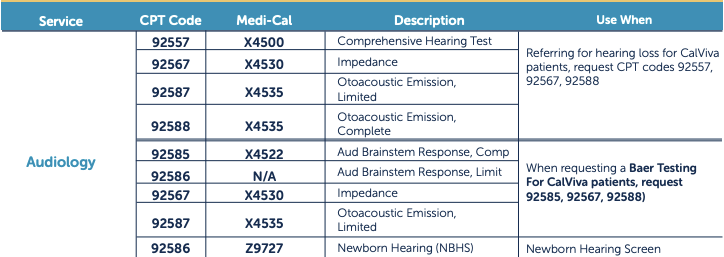

**Pretrained Models**

- `sbiobertresolve_cpt`
- `sbiobertresolve_cpt_augmented`
- `sbiobertresolve_cpt_procedures_augmented`
- `sbiobertresolve_cpt_procedures_measurements_augmented`

**We will create a pipeline to detect bodyparts and imaging tests entities and their relations. Then we will use these related chunks in CPT resolver model to get their CPT code.**

In [2]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetectorDL = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")


pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

# Named Entity Recognition for radiology reports.
clinical_ner = medical.NerModel.pretrained("jsl_rd_ner_wip_greedy_clinical", "en", "clinical/models") \
   .setInputCols(["sentence", "token", "word_embeddings"]) \
   .setOutputCol("ner")

ner_chunker = medical.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = medical.RelationExtractionModel()\
    .pretrained("re_bodypart_directions", "en", 'clinical/models')\
    .setInputCols(["word_embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["imagingtest-bodypart", "bodypart-imagingtest"])\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)
      

# Build up the pipeline
relation_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        pos_tagger,
        dependency_parser,
        clinical_ner,
        ner_chunker,
        re_model
        ])


empty_data = spark.createDataFrame([['']]).toDF("text")

rel_model = relation_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
Download done! Loading the resource.
[ / ]

[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
Download done! Loading the resource.


[Stage 4:============================================>              (3 + 1) / 4]

[ / ]


dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
Download done! Loading the resource.


[Stage 7:============================================>              (3 + 1) / 4]

[ \ ]

[OK!]
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.6 MB
Download done! Loading the resource.

re_bodypart_directions download started this may take some time.
re_bodypart_directions download started this may take some time.
Approximate size to download 9.2 MB
Download done! Loading the resource.

OK!]

In [3]:
light_rel_model = nlp.LightPipeline(rel_model)

In [4]:
text="Left shin pain. I have ordered x-ray of the left fibula and knee today. The patient will return to the clinic in 3 weeks. He is to call me in the interim for any problems."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

NameError: name 'get_relations_df' is not defined

**Now we can use get CPT codes of these related chunks.**

**Please note that you CAN NOT download this model using `.pretrained` method. To utilize this model, you need to have a valid CPT license. If you possess one and wish to use this model, kindly contact us at support@johnsnowlabs.com**

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
cpt_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("cpt_code")\
    .setDistanceFunction("EUCLIDEAN")


cpt_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        cpt_resolver])


cpt_lp = nlp.LightPipeline(cpt_pipelineModel)

In [36]:
text = 'fibula x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 25.3 ms, sys: 1.82 ms, total: 27.1 ms
Wall time: 219 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,fibula x-ray,0,11,73590,"[73590, 27676, 27455, 27712, 27457, 27707, 73550, 73090, 27635]","[Tibia and fibula X-ray, Incision of fibula, Incision of fibula, Incision of fibula, Incision of fibula, Incision of fibula, Femur X-ray (procedure), Forearm X-ray, Excision of lesion of fibula (procedure)]","[0.0895, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.1360, 0.1364, 0.1474]"


In [37]:
text = 'knee x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 26.8 ms, sys: 7.58 ms, total: 34.4 ms
Wall time: 220 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,knee x-ray,0,9,73564,"[73564, 73562, 73580, 27486, 1010487, 27540, 27332, 27310, 27334, 27335, 27330, 73600, 73610, 1005006, 27447, 27446]","[Knee X-ray, Knee X-ray, Knee arthrogram, Knee joint operations, Radiologic examination, knee, Operative procedure on knee, Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Ankle X-ray, Ankle X-ray, Arthrotomy, knee, Knee replacement, Knee replacement]","[0.0000, 0.0000, 0.0907, 0.1096, 0.1171, 0.1309, 0.1472, 0.1472, 0.1472, 0.1472, 0.1472, 0.1483, 0.1483, 0.1538, 0.1527, 0.1527]"


In [38]:
text="TECHNIQUE IN DETAIL: After informed consent was obtained from the patient and his mother, the chest was scanned with portable ultrasound."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,BodyPart,chest,ImagingTest,portable ultrasound,0.9999802


In [39]:
text = 'chest portable ultrasound'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 19.8 ms, sys: 12.1 ms, total: 31.9 ms
Wall time: 216 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,chest portable ultrasound,0,24,1010771,"[1010771, 76512, 76510, 3320F, 76977, 76999, 76377, 45391, 76881, 31620, 3319F, 76882]","[Diagnostic Ultrasound Procedures of the Chest, A scan ultrasound, A scan ultrasound, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan]","[0.1269, 0.1563, 0.1563, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582]"


In [40]:
text="This 73 y/o patient had Brain CT on 1/12/95, with progressive memory and cognitive decline since 8/11/94."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,BodyPart,Brain,ImagingTest,CT,0.9999999


In [41]:
text="MRI scan identified a soft tissue injury in the patient's leg, guiding the appropriate treatment plan."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,ImagingTest,MRI scan,BodyPart,leg,0.99996376


## Sentence Entity Resolver (SNOMED)

SNOMED CT is one of a suite of designated standards for use in U.S. Federal Government systems for the electronic exchange of clinical health information and is also a required standard in interoperability specifications of the U.S. Healthcare Information Technology Standards Panel. The clinical terminology is owned and maintained by SNOMED International, a not-for-profit association. 

SNOMED CT:

- Is the most comprehensive and precise, multilingual health terminology in the world.
- Has been, and continues to be, developed collaboratively to ensure it meets the diverse needs and expectations of the worldwide medical profession.
- Assists with the electronic exchange of clinical health information.
- Can be mapped to other coding systems, such as ICD-9 and ICD-10, which helps facilitate semantic interoperability.
- Is accepted as a common global language for health terms in over 50 countries.
- Is a resource with extensive, scientifically validated clinical content

**Pretrained SNOMED Resolver Models**

- `sbiobertresolve_snomed_auxConcepts_int`
- `sbiobertresolve_snomed_findings`
- `sbiobertresolve_snomed_findings_int`
- `sbiobertresolve_snomed_auxConcepts`
- `sbiobertresolve_snomed_procedures_measurements`
- `sbertresolve_snomed_bodyStructure_med`
- `sbiobertresolve_snomed_bodyStructure`
- `sbiobertresolve_snomed_findings_aux_concepts`
- `sbertresolve_snomed_conditions`
- `sbiobertresolve_snomed_drug`


In [42]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
snomed_ct_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("snomed_code")\
    .setDistanceFunction("EUCLIDEAN")

snomed_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        snomed_ct_resolver])

snomed_lp = nlp.LightPipeline(snomed_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_findings download started this may take some time.
sbiobertresolve_snomed_findings download started this may take some time.
Approximate size to download 611.3 MB
Download done! Loading the resource.

OK!]

In [45]:
text = 'brain tumor'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 16.4 ms, sys: 9.81 ms, total: 26.3 ms
Wall time: 522 ms


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,brain tumor,0,10,254935002,[brain tumor],"[254935002, 254936001, 448989001, 254938000, 724807008, 254945000, 126952004, 93727008, 277369003, 444545003, 1156461003, 762457009, 94225005, 93726004, 92030004, 126961004, 254941009, 1157141006]","[brain tumor, glial tumor of brain, carcinoma of brain, astrocytic tumor of brain, glioma of central nervous system, embryonal tumor of brain, neoplasm of brain, malignant neoplasm of brain, hamartoma of brain, glioma of brainstem, gliosarcoma of brain, astroblastoma of brain, secondary cancer of brain, malignant neoplasm of brain stem, benign brain tumor, neoplasm of brain stem, mixed glial tumor of brain, astroblastoma of central nervous system]","[0.0000, 0.0719, 0.0892, 0.0992, 0.1018, 0.1023, 0.1026, 0.1046, 0.1061, 0.1106, 0.1102, 0.1107, 0.1117, 0.1125, 0.1128, 0.1148, 0.1168, 0.1192]"


In [46]:
text = 'chest pain on left side'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 10.9 ms, sys: 13.1 ms, total: 24 ms
Wall time: 518 ms


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,chest pain on left side,0,22,285385002,[left sided chest pain],"[285385002, 427293006, 15743561000119103, 287047008, 316801000119101, 287045000, 425677008, 316841000119104, 316761000119109, 1260145003, 162049009, 426469008, 426483005, 425473004, 316771000119103, 339211000119104, 774135008, 285387005, 1076731000119106, 1119218004, 15916971000119109, 316821000119105]","[left sided chest pain, pain radiating to left side of chest, chronic pain of left upper limb, pain in left leg, pain of left lower leg, pain in left upper limb, pain radiating to left arm, pain of left upper arm, pain of left forearm, pain of left shoulder region, left flank pain, pain radiating to left leg, pain radiating to thoracic region left side, pain radiating to left shoulder, pain of left hand, pain of left eye, pain of left shoulder blade, left sided abdominal pain, joint pain in left hand, pain in left abdominal lumbar region, pain of left shoulder joint, pain of left thigh]","[0.0212, 0.0261, 0.0475, 0.0480, 0.0481, 0.0485, 0.0488, 0.0489, 0.0525, 0.0541, 0.0547, 0.0553, 0.0577, 0.0578, 0.0580, 0.0586, 0.0593, 0.0597, 0.0596, 0.0602, 0.0619, 0.0648]"


## Sentence Entity Resolver (LOINC)

- Logical Observation Identifiers Names and Codes (LOINC) is a database and universal standard for identifying medical laboratory observations. First developed in 1994, it was created and is maintained by the Regenstrief Institute, a US nonprofit medical research organization. LOINC was created in response to the demand for an electronic database for clinical care and management and is publicly available at no cost.

- It is endorsed by the American Clinical Laboratory Association. Since its inception, the database has expanded to include not just medical laboratory code names but also nursing diagnosis, nursing interventions, outcomes classification, and patient care data sets.

- LOINC applies universal code names and identifiers to medical terminology related to electronic health records. The purpose is to assist in the electronic exchange and gathering of clinical results (such as laboratory tests, clinical observations, outcomes management and research). LOINC has two main parts: laboratory LOINC and clinical LOINC.

**Pretrained LOINC Resovler Models**

- `sbiobertresolve_loinc`
- `sbiobertresolve_loinc_cased`
- `sbiobertresolve_loinc_augmented`
- `sbluebertresolve_loinc`
- `sbluebertresolve_loinc_uncased`




In [47]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
loinc_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_loinc_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("loinc_code")\
    .setDistanceFunction("EUCLIDEAN")

loinc_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        loinc_resolver])

loinc_lp = nlp.LightPipeline(loinc_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_loinc_augmented download started this may take some time.
sbiobertresolve_loinc_augmented download started this may take some time.
Approximate size to download 1 GB
Download done! Loading the resource.

OK!]

In [48]:
text = 'FLT3 gene mutation analysis'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 17.7 ms, sys: 8.89 ms, total: 26.6 ms
Wall time: 1.05 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,FLT3 gene mutation analysis,0,26,LP228450-5,[FLT3 gene targeted mutation analysis [FLT3 gene targeted mutation analysis]],"[LP228450-5, LP310331-6, LP228432-3, LP228446-3, LP228445-5, LP427344-9, LP229390-2, LP228738-3, LP229796-0, LP429666-3, LP229155-9, LP157803-0, LP228431-5, LP229833-1, LP435189-8, LP228570-0, LP229609-5, LP227517-2, 92843-2, LP229667-3, LP228546-0, LP228828-2, LP229608-7, LP228488-5]","[FLT3 gene targeted mutation analysis [FLT3 gene targeted mutation analysis], FLT3 gene p.Asp835 mutations [FLT3 gene p.Asp835 mutations], FGFR3 gene targeted mutation analysis [FGFR3 gene targeted mutation analysis], FLNA gene targeted mutation analysis [FLNA gene targeted mutation analysis], FLCN gene targeted mutation analysis [FLCN gene targeted mutation analysis], TNFAIP3 gene targeted mutation analysis [TNFAIP3 gene targeted mutation analysis], POU3F4 gene targeted mutation analysis [POU3F4 gene targeted mutation analysis], ITGB3 gene targeted mutation analysis [ITGB3 gene targeted mutation analysis], TGFB3 gene targeted mutation analysis [TGFB3 gene targeted mutation analysis], SF3B1 gene targeted mutation analysis [SF3B1 gene targeted mutation analysis], OPA3 gene targeted mutation analysis [OPA3 gene targeted mutation analysis], FLT3 gene.p.Asp835+Ile836 mutations [FLT3 gene.p.Asp835+Ile836 mutations], FGFR3 gene mutations tested for [FGFR3 gene mutations tested for], TRAF3 gene targeted mutation analysis [TRAF3 gene targeted mutation analysis], COL4A3 gene targeted mutation analysis [COL4A3 gene targeted mutation analysis], GPC3 gene targeted mutation analysis [GPC3 gene targeted mutation analysis], SH3TC2 gene targeted mutation analysis [SH3TC2 gene targeted mutation analysis], ABCA3 gene targeted mutation analysis [ABCA3 gene targeted mutation analysis], FLT3 p.D835 mutations [FLT3 gene p.Asp835 mutations [Presence] in Blood or Tissue by Molecular genetics method], SPG3A gene targeted mutation analysis [SPG3A gene targeted mutation analysis], GJB3 gene targeted mutation analysis [GJB3 gene targeted mutation analysis], LAMB3 gene targeted mutation analysis [LAMB3 gene targeted mutation analysis], SH3BP2 gene targeted mutation analysis [SH3BP2 gene targeted mutation analysis], FXN gene targeted mutation analysis [FXN gene targeted mutation analysis]]","[0.0354, 0.1032, 0.1021, 0.1111, 0.1135, 0.1182, 0.1258, 0.1249, 0.1285, 0.1303, 0.1255, 0.1308, 0.1316, 0.1287, 0.1310, 0.1328, 0.1346, 0.1315, 0.1358, 0.1351, 0.1352, 0.1339, 0.1390, 0.1347]"


In [49]:
text = 'FLT3 gene mutation analysis'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 14.8 ms, sys: 10.3 ms, total: 25.1 ms
Wall time: 1.05 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,FLT3 gene mutation analysis,0,26,LP228450-5,[FLT3 gene targeted mutation analysis [FLT3 gene targeted mutation analysis]],"[LP228450-5, LP310331-6, LP228432-3, LP228446-3, LP228445-5, LP427344-9, LP229390-2, LP228738-3, LP229796-0, LP429666-3, LP229155-9, LP157803-0, LP228431-5, LP229833-1, LP435189-8, LP228570-0, LP229609-5, LP227517-2, 92843-2, LP229667-3, LP228546-0, LP228828-2, LP229608-7, LP228488-5]","[FLT3 gene targeted mutation analysis [FLT3 gene targeted mutation analysis], FLT3 gene p.Asp835 mutations [FLT3 gene p.Asp835 mutations], FGFR3 gene targeted mutation analysis [FGFR3 gene targeted mutation analysis], FLNA gene targeted mutation analysis [FLNA gene targeted mutation analysis], FLCN gene targeted mutation analysis [FLCN gene targeted mutation analysis], TNFAIP3 gene targeted mutation analysis [TNFAIP3 gene targeted mutation analysis], POU3F4 gene targeted mutation analysis [POU3F4 gene targeted mutation analysis], ITGB3 gene targeted mutation analysis [ITGB3 gene targeted mutation analysis], TGFB3 gene targeted mutation analysis [TGFB3 gene targeted mutation analysis], SF3B1 gene targeted mutation analysis [SF3B1 gene targeted mutation analysis], OPA3 gene targeted mutation analysis [OPA3 gene targeted mutation analysis], FLT3 gene.p.Asp835+Ile836 mutations [FLT3 gene.p.Asp835+Ile836 mutations], FGFR3 gene mutations tested for [FGFR3 gene mutations tested for], TRAF3 gene targeted mutation analysis [TRAF3 gene targeted mutation analysis], COL4A3 gene targeted mutation analysis [COL4A3 gene targeted mutation analysis], GPC3 gene targeted mutation analysis [GPC3 gene targeted mutation analysis], SH3TC2 gene targeted mutation analysis [SH3TC2 gene targeted mutation analysis], ABCA3 gene targeted mutation analysis [ABCA3 gene targeted mutation analysis], FLT3 p.D835 mutations [FLT3 gene p.Asp835 mutations [Presence] in Blood or Tissue by Molecular genetics method], SPG3A gene targeted mutation analysis [SPG3A gene targeted mutation analysis], GJB3 gene targeted mutation analysis [GJB3 gene targeted mutation analysis], LAMB3 gene targeted mutation analysis [LAMB3 gene targeted mutation analysis], SH3BP2 gene targeted mutation analysis [SH3BP2 gene targeted mutation analysis], FXN gene targeted mutation analysis [FXN gene targeted mutation analysis]]","[0.0354, 0.1032, 0.1021, 0.1111, 0.1135, 0.1182, 0.1258, 0.1249, 0.1285, 0.1303, 0.1255, 0.1308, 0.1316, 0.1287, 0.1310, 0.1328, 0.1346, 0.1315, 0.1358, 0.1351, 0.1352, 0.1339, 0.1390, 0.1347]"


In [50]:
text = 'Hematocrit'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 17.2 ms, sys: 7.7 ms, total: 24.9 ms
Wall time: 966 ms


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,Hematocrit,0,9,LP15101-6,[Hematocrit [Hematocrit]],"[LP15101-6, LP308151-2, 32354-3, 20570-8, 11153-4, LP74090-9, 13508-7, 104874-3, 42908-4, LP29006-1, 11559-2, 71832-0, LP16437-3, LP14449-0, 41654-5, 41986-1, 104826-3, LP16428-2, 48703-3, 71828-8, 55103-6, 8478-0, 41655-2, LP30931-7]","[Hematocrit [Hematocrit], Hematocrit/Hemoglobin [Hematocrit/Hemoglobin], Hematocrit [Volume Fraction] of Arterial blood [Hematocrit [Volume Fraction] of Arterial blood], Hematocrit [Volume Fraction] of Blood [Hematocrit [Volume Fraction] of Blood], Hematocrit [Volume Fraction] of Body fluid [Hematocrit [Volume Fraction] of Body fluid], Hematocrit test status [Hematocrit test status], Microhematocrit [Hematocrit [Volume Fraction] of Cerebral spinal fluid by Centrifugation], Hematocrit Baseline [Hematocrit [Volume Fraction] of Blood --baseline], Hematocrit [Volume Fraction] of Capillary blood [Hematocrit [Volume Fraction] of Capillary blood], Blood volume [Blood volume], Fractional hemoglobin [Fractional oxyhemoglobin in Blood], Hematocrit [Pure volume fraction] of Arterial blood [Hematocrit [Pure volume fraction] of Arterial blood], Hemoglobin I [Hemoglobin I], Hemoglobin [Hemoglobin], Hematocrit [Volume Fraction] of Venous blood [Hematocrit [Volume Fraction] of Venous blood], Hematocrit Test Status/Results [Hematocrit test status/results Set CPHS], Hematocrit [Pure volume fraction] of Blood [Hematocrit [Pure volume fraction] of Blood], Hemoglobin F [Hemoglobin F], Hematocrit [Volume Fraction] of Blood by Estimated [Hematocrit [Volume Fraction] of Blood by Estimated], Hematocrit [Pure volume fraction] of Body fluid [Hematocrit [Pure volume fraction] of Body fluid], Blood output [Surgical operation note estimated blood loss Narrative], Mean blood pressure [Mean blood pressure], Hematocrit [Volume Fraction] of Mixed venous blood [Hematocrit [Volume Fraction] of Mixed venous blood], Hemoglobin M [Hemoglobin M]]","[0.0000, 0.0506, 0.0590, 0.0625, 0.0675, 0.0740, 0.0737, 0.0890, 0.1035, 0.1010, 0.1060, 0.1075, 0.1082, 0.1122, 0.1139, 0.1162, 0.1169, 0.1166, 0.1196, 0.1194, 0.1167, 0.1193, 0.1245, 0.1245]"


## Sentence Entity Resolver (UMLS)

- Unified Medical Language System (UMLS) integrates and distributes key terminology, classification and coding standards, and associated resources to promote creation of more effective and interoperable biomedical information systems and services, including electronic health records.

- The UMLS, or Unified Medical Language System, is a set of files and software that brings together many health and biomedical vocabularies and standards to enable interoperability between computer systems.

- The Metathesaurus forms the base of the UMLS and comprises over 1 million biomedical concepts and 5 million concept names, all of which stem from the over 100 incorporated controlled vocabularies and classification systems. Some examples of the incorporated controlled vocabularies are CPT, ICD-10, MeSH, SNOMED CT, DSM-IV, LOINC, WHO Adverse Drug Reaction Terminology, UK Clinical Terms, RxNorm, Gene Ontology, and OMIM

**Pretrained Models**

- `sbiobertresolve_umls_findings`
- `sbiobertresolve_umls_major_concepts`
- `sbiobertresolve_umls_disease_syndrome`
- `sbiobertresolve_umls_clinical_drugs`

In [6]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
umls_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_umls_major_concepts", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("umls_code")\
    .setDistanceFunction("EUCLIDEAN")

umls_pipelineModel = nlp.PipelineModel(stages = [
    documentAssembler,
    sbert_embedder,
    umls_resolver])

umls_lp = nlp.LightPipeline(umls_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
Download done! Loading the resource.
[ — ]

[OK!]
sbiobertresolve_umls_major_concepts download started this may take some time.
sbiobertresolve_umls_major_concepts download started this may take some time.
Approximate size to download 4 GB
Download done! Loading the resource.

OK!]

In [7]:
# Injuries & poisoning
text = 'food poisoning'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 27.6 ms, sys: 16 ms, total: 43.6 ms
Wall time: 47.6 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,food poisoning,0,13,C0016479,[food poisoning],"[C0016479, C0411266, C0349783, C1278392, C1271087, C0564911, C0161651, C1409472, C0275107, C1264615, C0152498, C0178496, C0161615, C0559583, C1272775, C3649056]","[food poisoning, chemical food poisoning, infective food poisoning, food poisoning contact, suspected food poisoning, food poisoning-accident, dietetic poisoning, poisoning; noxious foodstuffs, poisoning by ingestion of insect-infested food (disorder), clostridium food poisoning, bact food poisoning nec, bacterial food poisoning, digestant poisoning, contaminated food intake, burns food, food toxicity poisoning accidental]","[0.0000, 0.0294, 0.0322, 0.0512, 0.0685, 0.0706, 0.0739, 0.0782, 0.0807, 0.0832, 0.0860, 0.0863, 0.0871, 0.0884, 0.0913, 0.0951]"


In [8]:
# clinical findings
text = 'type two diabetes mellitus'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 22.2 ms, sys: 7.79 ms, total: 29.9 ms
Wall time: 2.69 s


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,type two diabetes mellitus,0,25,C4016960,"[type 2 diabetes mellitus, association with]","[C4016960, C4014362, C4016735, C3532488, C0260526, C2733146, C1320657, C3837967, C1313937, C0455488, C3532621, C4017629]","[type 2 diabetes mellitus, association with, type 2 diabetes mellitus (t2d), type 2 diabetes mellitus, modifier of, history of diabetes mellitus type 2 (situation), fh - diabetes mellitus, uncontrolled type 2 diabetes mellitus (disorder), diabete type, diabetes mellitus type 2 susceptibility, fh: diabetes mellitus, h/o: diabetes mellitus, suspected diabetes mellitus, diabetes mellitus, type ii, digenic]","[0.0285, 0.0438, 0.0460, 0.0568, 0.0583, 0.0616, 0.0618, 0.0638, 0.0697, 0.0781, 0.0828, 0.0910]"


## Sentence Entity Resolver (HPO)

The Human Phenotype Ontology (HPO) is a formal ontology of human phenotypes. Developed in collaboration with members of the Open Biomedical Ontologies Foundry, HPO currently contains over 13,000 terms and over 156,000 annotations to hereditary diseases. Data from Online Mendelian Inheritance in Man and medical literature were used to generate the terms currently in the HPO. The ontology contains over 50,000 annotations between phenotypes and hereditary disease.

Each term in the HPO describes a clinical abnormality. These may be general terms, such as Abnormal ear morphology or very specific ones such as Chorioretinal atrophy. Each term is also assigned to one of the five subontologies. The terms have a unique ID such as HP:0001140 and a label such as *Epibulbar dermoid*.

In [9]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
hpo_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_HPO", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("hpo_code")\
    .setDistanceFunction("EUCLIDEAN")

hpo_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        hpo_resolver])

hpo_lp = nlp.LightPipeline(hpo_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_HPO download started this may take some time.
sbiobertresolve_HPO download started this may take some time.
Approximate size to download 97.9 MB
Download done! Loading the resource.

OK!]

In [10]:
text = 'schizophrenia '

%time get_codes (hpo_lp, text, vocab='hpo_code')

CPU times: user 13.7 ms, sys: 13.3 ms, total: 27 ms
Wall time: 262 ms


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,schizophrenia,0,13,HP:0100753,[schizophrenia],"[HP:0100753, HP:0000709, HP:0007302, HP:0000708, HP:0000725, HP:0011511, HP:0012077, HP:0001345, HP:0030325, HP:0012075, HP:0000722, HP:0033512, HP:0012076, HP:0100923, HP:0002072, HP:0033715, HP:0010891, HP:0011626, HP:0100656, HP:0033516, HP:0008404, HP:0002269]","[schizophrenia, psychosis, bipolar disorder, psychiatric disorders, psychotic episodes, macular schisis, histrionic personality disorder, psychotic mentation, cervicomedullary schisis, personality disorder, obsessive compulsive disorder, stimulant dependence, borderline personality disorder, clavicular sclerosis, choreatic disease, mesial temporal sclerosis, scheuermann disease, scimitar syndrome, thoracoabdominal schisis, benzodiazepine dependence, onychodystrophy, migrational brain disorder]","[0.0000, 0.1172, 0.1488, 0.1599, 0.1877, 0.1898, 0.1923, 0.2033, 0.2163, 0.2113, 0.2166, 0.2257, 0.2202, 0.2345, 0.2431, 0.2389, 0.2497, 0.2438, 0.2578, 0.2483, 0.2604, 0.2455]"


In [11]:
text = 'Abnormality of the upper limb'

%time get_codes (hpo_lp, text, vocab='hpo_code')

CPU times: user 11.8 ms, sys: 12.2 ms, total: 24 ms
Wall time: 253 ms


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,Abnormality of the upper limb,0,28,HP:0002817,[abnormality of the upper limb],"[HP:0002817, HP:0001454, HP:0009810, HP:0001446, HP:0100560, HP:0001457, HP:0040064, HP:0009808, HP:0040286, HP:0100022, HP:0002087, HP:0009127, HP:0000177, HP:0001999, HP:0011729, HP:0002813, HP:0001367, HP:0001155, HP:0000496, HP:0011297]","[abnormality of the upper limb, abnormality of the upper arm, abnormality of upper limb joint, abnormal upper limb muscles, upper limb asymmetry, abnormality of the musculature of the upper arm, abnormality of limbs, diaphyseal abnormality of the upper limbs, abnormality of axial muscles, abnormality of movement, abnormality of the upper respiratory tract, abnormal limb muscles, abnormality of upper lip, abnormal facial shape, abnormality of joint mobility, limb abnormality, abnormality of the joints, abnormality of the hand, abnormal eye movement, abnormality of digit]","[0.0000, 0.0141, 0.0195, 0.0423, 0.0465, 0.0532, 0.0585, 0.0609, 0.0623, 0.0648, 0.0654, 0.0678, 0.0690, 0.0701, 0.0713, 0.0723, 0.0734, 0.0731, 0.0737, 0.0784]"


In [12]:
text = 'Muscle haemorrhage'

%time get_codes (hpo_lp, text, vocab='hpo_code')

CPU times: user 16.3 ms, sys: 6.53 ms, total: 22.8 ms
Wall time: 230 ms


,chunks,begin,end,code,resolution,all_codes,all_resolutions,all_cos_distances
0,Muscle haemorrhage,0,17,HP:0040242,[muscle haemorrhage],"[HP:0040242, HP:0012233, HP:0040223, HP:0025582, HP:0031611, HP:0001933, HP:0002239, HP:0031805, HP:0005261, HP:0011029, HP:0032990, HP:0025239, HP:0003713, HP:0031803]","[muscle haemorrhage, intramuscular hemorrhage, pulmonary haemorrhage, submacular haemorrhage, sub-ilm haemorrhage, subcutaneous haemorrhage, gi hemorrhage, intraretinal haemorrhage, joint haemorrhage, internal haemorrhage, localised pulmonary haemorrhage, subhyaloid haemorrhage, muscle fibre necrosis, fundus haemorrhage]","[0.0000, 0.0749, 0.1115, 0.1187, 0.1209, 0.1211, 0.1261, 0.1263, 0.1281, 0.1290, 0.1368, 0.1510, 0.1450, 0.1466]"


## Assertion Filterer - Using with Resolvers


We can determine the **assertion status** of the entities and filter by `present` with `AssertionFilterer` and then use it in the **Resolver** model.

In [9]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\

ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["Problem"])

clinical_assertion = medical.AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = medical.AssertionFilterer()\
    .setInputCols("sentence","ner_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setCaseSensitive(False)\
    .setWhiteList(["PREsent"])

c2doc = nlp.Chunk2Doc()\
    .setInputCols("assertion_filtered")\
    .setOutputCol("doc_ner_chunk") 

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

nlpPipeline = nlp.Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      clinical_assertion,
      assertion_filterer,
      c2doc,
      sbert_embedder,
      icd_resolver
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
assertionFilter_model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
ner_clinical download started this may take some time.
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.

assertion_dl download started this may take some time.
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
Download done! Loading the resource.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.2 GB
Download done! Loading the resource.

OK!]

In [10]:
clinical_note = ["""
Patient with severe fever and sore throat.  He shows no stomach pain and he maintained on an epidural and PCA for pain control.
He also became short of breath with climbing a flight of stairs. After CT, lung tumor located at the right lower lobe. Father with Alzheimer.
"""]

light_model = nlp.LightPipeline(assertionFilter_model)

light_result = light_model.fullAnnotate(clinical_note)[0]

In [11]:
light_result.keys()

dict_keys(['assertion_filtered', 'document', 'ner_chunk', 'assertion', 'sentence_embeddings', 'icd10cm_code', 'token', 'ner', 'embeddings', 'doc_ner_chunk', 'sentence'])

In [14]:
chunks=[]
entities=[]
status=[]
confidence=[]

for m, n in zip(light_result['ner_chunk'],light_result["assertion"] ):
    
    chunks.append(m.result)
    entities.append(m.metadata['entity']) 
    status.append(n.result)
    confidence.append(n.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,'assertion':status, 'confidence':confidence })

df

,chunks,entities,assertion,confidence
0,severe fever,PROBLEM,present,1.0
1,sore throat,PROBLEM,present,1.0
2,stomach pain,PROBLEM,absent,0.8322
3,pain control,PROBLEM,hypothetical,0.9441
4,short of breath,PROBLEM,conditional,0.9895
5,lung tumor,PROBLEM,present,0.9961
6,Alzheimer,PROBLEM,associated_with_someone_else,0.996


In [15]:
#from sparknlp_display import EntityResolverVisualizer

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result, 'ner_chunk', 'icd10cm_code')

In [16]:
chunks=[]
entities=[]
status=[]
confidence=[]

for m in light_result["assertion_filtered"] :
    
    chunks.append(m.result)
    entities.append(m.metadata['entity']) 
    status.append(m.metadata['assertion'])
    confidence.append(m.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,'assertion':status, 'confidence':confidence })

df

,chunks,entities,assertion,confidence
0,severe fever,PROBLEM,present,0.902
1,sore throat,PROBLEM,present,0.98815
2,lung tumor,PROBLEM,present,0.9019


In [17]:
#from sparknlp_display import EntityResolverVisualizer

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result, 'assertion_filtered', 'icd10cm_code')

## Router - Using Resolver Models Together

- Normally, when we need to use more than one sentence entity resolver models in the same pipeline, we used to hit `BertSentenceEmbeddings` annotator more than once given the number of different resolver models in the same pipeline. Now we are introducing a solution with the help of `Router` annotator that could allow us to feed all the NER chunks to `BertSentenceEmbeddings` at once and then route the output of Sentence Embeddings to different resolver models needed.

- In this example, lets use `sbiobertresolve_rxnorm` RxNorm model and `sbiobertresolve_icd10cm_slim_billable_hcc` ICD10CM-HCC models together. First we will get the `PROBLEM` entities form `ner_clinical` model and then get the `DRUG` entities from `ner_posology` model. Then we will merge them and use the `Chunk2Doc` annotator to create sentence chunks to populate Sentence Embeddings column. Then, we route the embeddings of `PROBLEM` entities to ICD10CM model and embeddings of `DRUG` entities to RxNorm model at the same time.

In [13]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetector()\
    .setInputCols("document")\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("word_embeddings")

# to get PROBLEM entitis
clinical_ner = medical.NerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("clinical_ner")

clinical_ner_chunk = medical.NerConverterInternal()\
    .setInputCols("sentence","token","clinical_ner")\
    .setOutputCol("clinical_ner_chunk")\
    .setWhiteList(["PROBLEM"])

# to get DRUG entities 
posology_ner = medical.NerModel().pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("posology_ner")

posology_ner_chunk = medical.NerConverterInternal()\
    .setInputCols("sentence","token","posology_ner")\
    .setOutputCol("posology_ner_chunk")\
    .setWhiteList(["DRUG"])

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("clinical_ner_chunk","posology_ner_chunk")\
    .setOutputCol("final_ner_chunk")\
    .setMergeOverlapping(False)


# convert chunks to doc to get sentence embeddings of them
chunk2doc = nlp.Chunk2Doc().setInputCols("final_ner_chunk").setOutputCol("doc_final_chunk")


sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["doc_final_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

# filter PROBLEM entity embeddings
router_sentence_icd10 = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

# filter DRUG entity embeddings
router_sentence_rxnorm = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["DRUG"]) \
    .setOutputCol("drug_embeddings")

# use problem_embeddings only
icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


# use drug_embeddings only
rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")


pipeline = nlp.Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    clinical_ner_chunk,
    posology_ner,
    posology_ner_chunk,
    chunk_merger,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
ner_clinical download started this may take some time.
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.
[OK!]
ner_posology download started this may take some time.
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
Download done! Loading the resource.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
Approximate size to download 417.9 MB
Download done! Loading the resource.
[OK!]
sbiobertresolve_rxnorm

In [14]:
clinical_note = """The patient is a 41-year-old Vietnamese female with a cough that started last week. 
She has had right-sided chest pain radiating to her back with fever starting yesterday. 
She has a history of pericarditis in May 2006 and developed cough with right-sided chest pain. 
MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.
"""

In [15]:
df = spark.createDataFrame([[clinical_note]]).toDF("text")

result = model.transform(df)

In [17]:
icd10_result = get_codes_from_df(result, 'clinical_ner_chunk', 'icd10cm_code', aux=True)

In [18]:
# extract HCC informationinto different columns

icd10_result["billable"] = icd10_result["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
icd10_result["hcc_status"] = icd10_result["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_result["hcc_code"] = icd10_result["aux_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

icd10_result.drop("aux_list", axis=1, inplace= True)

In [20]:
icd10_result.head(15)

,sent_id,ner_chunk,entity,icd10cm_code,resolution,all_codes,all_resolutions,billable,hcc_status,hcc_code
0,0,a cough,PROBLEM,R05,cough [cough],"[R05, R05.3, R05.1, A37, R05.2, R06.01, R06.7, R06.0, R06.2, R06, J38.4, R05.4, G44.83, R00.2, R06.00, R07.1, R07.0, R09.81, R12, S22.5, R49.0, R07, L29, R06.83, G47.51]","[cough [cough], chronic cough [chronic cough], acute cough [acute cough], whooping cough [whooping cough], subacute cough [subacute cough], orthopnea [orthopnea], sneezing [sneezing], dyspnea [dyspnea], wheezing [wheezing], abnormalities of breathing [abnormalities of breathing], edema of larynx [edema of larynx], cough syncope [cough syncope], primary cough headache [primary cough headache], palpitations [palpitations], dyspnea, unspecified [dyspnea, unspecified], chest pain on breathing [chest pain on breathing], pain in throat [pain in throat], nasal congestion [nasal congestion], heartburn [heartburn], flail chest [flail chest], dysphonia [dysphonia], pain in throat and chest [pain in throat and chest], pruritus [pruritus], snoring [snoring], confusional arousals [confusional arousals]]","[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,right-sided chest pain,PROBLEM,R10.11,right upper quadrant pain [right upper quadrant pain],"[R10.11, M79.621, M79.604, M79.601, M25.511, M79.631, R07.1, M79.661, M79.651, M25.551, M79.641, M25.531, G90.511, M79.644, H57.11, M25.541, R10.31, R07.89, M25.521, M25.561, G90.521, R07.2, I83.811, M79.671, R07]","[right upper quadrant pain [right upper quadrant pain], pain in right upper arm [pain in right upper arm], pain in right leg [pain in right leg], pain in right arm [pain in right arm], pain in right shoulder [pain in right shoulder], pain in right forearm [pain in right forearm], chest pain on breathing [chest pain on breathing], pain in right lower leg [pain in right lower leg], pain in right thigh [pain in right thigh], pain in right hip [pain in right hip], pain in right hand [pain in right hand], pain in right wrist [pain in right wrist], complex regional pain syndrome i of right upper limb [complex regional pain syndrome i of right upper limb], pain in right finger(s) [pain in right finger(s)], ocular pain, right eye [ocular pain, right eye], pain in joints of right hand [pain in joints of right hand], right lower quadrant pain [right lower quadrant pain], other chest pain [other chest pain], pain in right elbow [pain in right elbow], pain in right knee [pain in right knee], complex regional pain syndrome i of right lower limb [complex regional pain syndrome i of right lower limb], precordial pain [precordial pain], varicose veins of right lower extremity with pain [varicose veins of right lower extremity with pain], pain in right foot [pain in right foot], pain in throat and chest [pain in throat and chest]]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1,fever,PROBLEM,A68,relapsing fevers [relapsing fevers],"[A68, A78, R50.2, M04.1, A96.2, A68.9, R11.0, T67.7, A79.0, A92.1, R50.82, R50.9, R51, R50.8, T67.6, R50.83, R60.1, R10.81, A68.0, R09.81, A92.4, L29, R10.817, A95, R23.1]","[relapsing fevers [relapsing fevers], q fever [q fever], drug induced fever [drug induced fever], periodic fever syndromes [periodic fever syndromes], lassa fever [lassa fever], relapsing fever, unspecified [relapsing fever, unspecified], nausea [nausea], heat edema [heat edema], trench fever [trench fever], o'nyong-nyong fever [o'nyong-nyong fever], postprocedural fever [postprocedural fever], fever, unspecified [fever, unspecified], headache [headache], other specified fever [other specified fever], heat fatigue, transient

Now lets get RxNorm codes from our results.

In [22]:
rxnorm_result = get_codes_from_df(result, 'posology_ner_chunk', 'rxnorm_code', aux=False)

rxnorm_result.head()

,sent_id,ner_chunk,entity,rxnorm_code,resolutions,all_codes,all_resolutions
0,4,Coumadin,DRUG,202421,coumadin [coumadin],"[202421, 2898, 1855075, 128793, 1598, 152085, 218274, 21732, 1435932, 227590, 202392, 87866, 1603522, 5011, 402786, 216785, 370743, 202862, 151531, 1317116, 220917, 1046235, 217319, 216474, 216119]","[coumadin [coumadin], coumarin [coumarin], coumaran [coumaran], vicodin [vicodin], dicoumarol [dicumarol], mycifradin [mycifradin], medcodin [medcodin], cresatin [cresatin], reumacetin [reumacetin], geocillin [geocillin], garamycin [garamycin], ardeparin [ardeparin], glabridin [glabridin], gramicidin [gramicidin], policresulen Vaginal Gel, duraganidin nr [duraganidin nr], acenocoumarol Oral Tablet, cleocin [cleocin], codafen [codafen], velafermin [velafermin], vivarin [vivarin], cosamin [cosamin], gennin-fc [gennin-fc], dermacin [dermacin], codamine [codamine]]"
1,6,Amiodarone,DRUG,1663223,amiodarone Injection,"[1663223, 1151983, 1663270, 1151982, 203114, 377132, 1151981, 832845, 727379, 370568, 1944369, 151347, 722, 1000084, 5936, 832848, 374399, 833534, 17767, 1153467, 1364410, 151908, 5981, 236131]","[amiodarone Injection, amiodarone pill [amiodarone pill], amiodarone injection [nexterone] [amiodarone injection [nexterone]], amiodarone oral product [amiodarone oral product], amiodarone hydrochloride [amiodarone hydrochloride], amiodarone injectable solution [amiodarone injectable solution], amiodarone injectable product [amiodarone injectable product], amiodarone injectable solution [nexterone] [amiodarone injectable solution [nexterone]], amiodarone prefilled syringe [amiodarone prefilled syringe], amiodarone oral tablet [amiodarone oral tablet], amantadine Extended Release Oral Capsule, amsidine [amsidine], amoxapine [amoxapine], alcaftadine Ophthalmic Solution, adipiodone [iodipamide], amiodarone prefilled syringe [nexterone] [amiodarone prefilled syringe [nexterone]], adenosine injectable solution [adenosine injectable solution], amiodarone injectable solution [cordarone] [amiodarone injectable solution [cordarone]], amlodipine [amlodipine], adenosine injectable product [adenosine injectable product], ioxapine [ioxapine], iopidine [iopidine], iproniazid [iproniazid], codeine anhyd [codeine anhyd]]"


### Using Router with Single NER Model

**If we want to get entities from only ONE NER model, it will be sufficient to feed the resolver models only with sentence embeddings from the `Router`. In the example below, we use `ner_clinical` model to get the `PROBLEM`,`TREATMENT` entities. Then we will feed the ICD10CM resolver model with the sentence embeddings of `PROBLEM` entities (`problem_embeddings`), and RxNorm resolver with `TREATMENT` entities (`drug_embeddings`) from the `Router`.**

In [7]:
ner = medical.NerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_chunk = medical.NerConverterInternal()\
    .setInputCols("sentence","token","ner")\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["PROBLEM","TREATMENT"])


chunk2doc = nlp.Chunk2Doc().setInputCols("ner_chunk").setOutputCol("doc_jsl_chunk")

sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["doc_jsl_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

router_sentence_icd10 = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

router_sentence_rxnorm = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["TREATMENT"]) \
    .setOutputCol("drug_embeddings")


icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline = nlp.Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner,
    ner_chunk,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
resolver_model = resolver_pipeline.fit(empty_data)

ner_clinical download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.

OK!]

In [26]:
light_model = nlp.LightPipeline(resolver_model)

light_result = light_model.fullAnnotate(clinical_note)

In [28]:
from sparknlp_jsl.pipeline_tracer import PipelineTracer

In [29]:
pipeline_tracer = PipelineTracer(resolver_model)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "router_pipeline"})
column_maps.keys()

dict_keys(['document_identifier', 'document_text', 'entities', 'assertions', 'resolutions', 'relations', 'summaries', 'deidentifications', 'classifications'])

In [30]:
pipeline_parser = medical.PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result)

#result['result'][0]

In [31]:
def process_icd_data(result):
    entities_df = pd.DataFrame(result['result'][0]['entities'])
    resolutions_df = pd.DataFrame(result['result'][0]['resolutions'])

    df = pd.merge(entities_df, resolutions_df, on=['chunk_id', 'chunk']).drop(columns='chunk_id')

    df['all_codes'] = df['all_k_codes'].str.split(':::')
    df['all_resolutions'] = df['all_k_resolutions'].str.split(':::')
    df['hcc_list'] = df['all_k_aux_labels'].apply(lambda x: [item.split('||') for item in x.split(':::')])

    df[['billable', 'hcc_status', 'hcc_code']] = pd.DataFrame(
        df['hcc_list'].apply(lambda x: list(zip(*[(item[0], item[1] if len(item) > 1 else '0', item[2] if len(item) > 2 else '0') for item in x]))).tolist()
    )

    columns_to_drop = ["hcc_list", "all_k_resolutions", "all_k_aux_labels", "all_k_codes", "all_k_distances"]
    return df.drop(columns=columns_to_drop)

single_icd_df = process_icd_data(result)
single_icd_df

,chunk,begin,end,ner_label,ner_source,ner_confidence,vocab,code,resolutions,confidence,all_codes,all_resolutions,billable,hcc_status,hcc_code
0,a cough,52,58,PROBLEM,ner_chunk,0.9635,icd10cm_code,R05,cough [cough],0.7676,"[R05, R05.3, R05.1, A37, R05.2, R06.01, R06.7, R06.0, R06.2, R06, J38.4, R05.4, G44.83, R00.2, R06.00, R07.1, R07.0, R09.81, R12, S22.5, R49.0, R07, L29, R06.83, G47.51]","[cough [cough], chronic cough [chronic cough], acute cough [acute cough], whooping cough [whooping cough], subacute cough [subacute cough], orthopnea [orthopnea], sneezing [sneezing], dyspnea [dyspnea], wheezing [wheezing], abnormalities of breathing [abnormalities of breathing], edema of larynx [edema of larynx], cough syncope [cough syncope], primary cough headache [primary cough headache], palpitations [palpitations], dyspnea, unspecified [dyspnea, unspecified], chest pain on breathing [chest pain on breathing], pain in throat [pain in throat], nasal congestion [nasal congestion], heartburn [heartburn], flail chest [flail chest], dysphonia [dysphonia], pain in throat and chest [pain in throat and chest], pruritus [pruritus], snoring [snoring], confusional arousals [confusional arousals]]","(0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1)","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,right-sided chest pain,97,118,PROBLEM,ner_chunk,0.97246665,icd10cm_code,R10.11,right upper quadrant pain [right upper quadrant pain],0.1088,"[R10.11, M79.621, M79.604, M79.601, M25.511, M79.631, R07.1, M79.661, M79.651, M25.551, M79.641, M25.531, G90.511, M79.644, H57.11, M25.541, R10.31, R07.89, M25.521, M25.561, G90.521, R07.2, I83.811, M79.671, R07]","[right upper quadrant pain [right upper quadrant pain], pain in right upper arm [pain in right upper arm], pain in right leg [pain in right leg], pain in right arm [pain in right arm], pain in right shoulder [pain in right shoulder], pain in right forearm [pain in right forearm], chest pain on breathing [chest pain on breathing], pain in right lower leg [pain in right lower leg], pain in right thigh [pain in right thigh], pain in right hip [pain in right hip], pain in right hand [pain in right hand], pain in right wrist [pain in right wrist], complex regional pain syndrome i of right upper limb [complex regional pain syndrome i of right upper limb], pain in right finger(s) [pain in right finger(s)], ocular pain, right eye [ocular pain, right eye], pain in joints of right hand [pain in joints of right hand], right lower quadrant pain [right lower quadrant pain], other chest pain [other chest pain], pain in right elbow [pain in right elbow], pain in right knee [pain in right knee], complex regional pain syndrome i of right lower limb [complex regional pain syndrome i of right lower limb], precordial pain [precordial pain], varicose veins of right lower extremity with pain [varicose veins of right lower extremity with pain], pain in right foot [pain in right foot], pain in throat and chest [pain in throat and chest]]","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,fever,147,151,PROBLEM,ner_chunk,0.9998,icd10cm_code,A68,relapsing fevers [relapsing fevers],0.3923,"[A68, A78, R50.2, M04.1, A96.2, A68.9, R11.0, T67.7, A79.0, A92.1, R50.82, R50.9, R51, R50.8, T67.6, R50.83, R60.1, R10.81, A68.0, R09.81, A92.4, L29, R10.817, A95, R23.1]","[relapsing fevers [relapsing fevers], q fever [q fever], drug induced fever [drug induced fever], periodic fever syndromes [periodic fever syndromes], lassa fever [lassa fever], relapsing fever, unspecified [relapsing fever, unspecified], nausea [nausea], heat edema [heat edema], trench fever [trench fever], o'nyong-nyong fever [o'nyong-nyong fever], postproced

In [32]:
rxnorm_df = pd.DataFrame([res for res in result['result'][0]['resolutions'] if res['vocab'] == 'rxnorm_code'])

entities_df = pd.DataFrame(result['result'][0]['entities'])

single_rx_df = pd.merge(entities_df, rxnorm_df, on=['chunk_id', 'chunk']).drop(columns=['chunk_id', 'all_k_aux_labels', 'all_k_distances'])

single_rx_df['all_codes'] = single_rx_df['all_k_codes'].apply(lambda x: x.split(':::'))
single_rx_df['all_resolutions'] = single_rx_df['all_k_resolutions'].apply(lambda x: x.split(':::'))

single_rx_df.drop(columns=['all_k_codes', 'all_k_resolutions'], inplace=True)

single_rx_df

,chunk,begin,end,ner_label,ner_source,ner_confidence,vocab,code,resolutions,confidence,all_codes,all_resolutions
0,Coumadin,285,292,TREATMENT,ner_chunk,0.9987,rxnorm_code,202421,coumadin [coumadin],0.9921,"[202421, 2898, 1855075, 128793, 1598, 152085, 218274, 21732, 1435932, 227590, 202392, 87866, 1603522, 5011, 402786, 216785, 370743, 202862, 151531, 1317116, 220917, 1046235, 217319, 216474, 216119]","[coumadin [coumadin], coumarin [coumarin], coumaran [coumaran], vicodin [vicodin], dicoumarol [dicumarol], mycifradin [mycifradin], medcodin [medcodin], cresatin [cresatin], reumacetin [reumacetin], geocillin [geocillin], garamycin [garamycin], ardeparin [ardeparin], glabridin [glabridin], gramicidin [gramicidin], policresulen Vaginal Gel, duraganidin nr [duraganidin nr], acenocoumarol Oral Tablet, cleocin [cleocin], codafen [codafen], velafermin [velafermin], vivarin [vivarin], cosamin [cosamin], gennin-fc [gennin-fc], dermacin [dermacin], codamine [codamine]]"
1,Amiodarone,372,381,TREATMENT,ner_chunk,0.9995,rxnorm_code,1663223,amiodarone Injection,0.9944,"[1663223, 1151983, 1663270, 1151982, 203114, 377132, 1151981, 832845, 727379, 370568, 1944369, 151347, 722, 1000084, 5936, 832848, 374399, 833534, 17767, 1153467, 1364410, 151908, 5981, 236131]","[amiodarone Injection, amiodarone pill [amiodarone pill], amiodarone injection [nexterone] [amiodarone injection [nexterone]], amiodarone oral product [amiodarone oral product], amiodarone hydrochloride [amiodarone hydrochloride], amiodarone injectable solution [amiodarone injectable solution], amiodarone injectable product [amiodarone injectable product], amiodarone injectable solution [nexterone] [amiodarone injectable solution [nexterone]], amiodarone prefilled syringe [amiodarone prefilled syringe], amiodarone oral tablet [amiodarone oral tablet], amantadine Extended Release Oral Capsule, amsidine [amsidine], amoxapine [amoxapine], alcaftadine Ophthalmic Solution, adipiodone [iodipamide], amiodarone prefilled syringe [nexterone] [amiodarone prefilled syringe [nexterone]], adenosine injectable solution [adenosine injectable solution], amiodarone injectable solution [cordarone] [amiodarone injectable solution [cordarone]], amlodipine [amlodipine], adenosine injectable product [adenosine injectable product], ioxapine [ioxapine], iopidine [iopidine], iproniazid [iproniazid], codeine anhyd [codeine anhyd]]"


## MultiChunkToDoc

MultiChunkToDoc combines chunks into a document output type, sets separators via setSeparator(“,”), filters entities label, and structures annotations with details such as start and end points, results, and metadata; the workflow integrates steps from NER to Resolver through a series of transformations including Chunks, MultiChunksToDoc, and Embeddings.

In [8]:
multi_chunk2_doc = medical.MultiChunk2Doc() \
    .setInputCols(["ner_chunk"]) \
    .setOutputCol("new_document") \
    .setWhiteList(["Problem"]) \
    .setCaseSensitive(False) \
    .setPrefix("< ") \
    .setSeparator(", ") \
    .setSuffix(" >") \

sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["new_document"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        ner,
        ner_chunk,
        multi_chunk2_doc,
        sbiobert_embeddings,
        icd_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
resolver_model = resolver_pipeline.fit(empty_data)

data = spark.createDataFrame([
["""She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation.
Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity"""]
]).toDF("text")

result = resolver_model.transform(data)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.2 GB
Download done! Loading the resource.

OK!]

In [9]:
resolver_model.stages

[DocumentAssembler_47f6befbe259,
 SentenceDetector_929f4397dca7,
 REGEX_TOKENIZER_26a17a476227,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NER_CONVERTER_b3d8520f77db,
 MultiChunk2Doc_15305d52e90a,
 BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc,
 ENTITY_43bcc4c3bbef]

In [10]:
result.select("new_document.result").show(truncate=False)

[Stage 23:======================================>                   (2 + 1) / 3]

+----------------------------------------------------------------+
|result                                                          |
+----------------------------------------------------------------+
|[< T2DM, HTG, dry oral mucosa, tenderness, guarding, rigidity >]|
+----------------------------------------------------------------+



In [13]:
icd10_result = get_codes_from_df(result, 'new_document', 'icd10cm_code', aux=True)

In [14]:
icd10_result

,sent_id,ner_chunk,entity,icd10cm_code,resolution,all_codes,all_resolutions,aux_list
0,None,"< T2DM, HTG, dry oral mucosa, tenderness, guarding, rigidity >",None,K13.0,o/e - dry/cracked lips [diseases of lips],"[K13.0, I70.529, R23.8, L67.8, J39.2, L85.3, I70.629, G90.50, N89.8, I70.528, I70.329, I70.628, R05, G50.8, R19.8]","[o/e - dry/cracked lips [diseases of lips], athscl nonaut bio bypass of extrm w rest pain, unsp extrm [atherosclerosis of nonautologous biological bypass graft(s) of the extremities with rest pain, unspecified extremity], o/e - abd.skin dry-dehydration [other skin changes], o/e - dryness of hair [other hair color and hair shaft abnormalities], pharyngeal dryness (finding) [other diseases of pharynx], c/o: dry skin (context-dependent category) [xerosis cutis], athscl nonbiol bypass of the extrm w rest pain, unsp extrm [atherosclerosis of nonbiological bypass graft(s) of the extremities with rest pain, unspecified extremity], sip - sympathetically independent pain [complex regional pain syndrome i, unspecified], vaginal dryness (disorder) [other specified noninflammatory disorders of vagina], athscl nonaut bio bypass of the extrm w rest pain, oth extrm [atherosclerosis of nonautologous biological bypass graft(s) of the extremities with rest pain, other extremity], athscl unsp type bypass of the extrm w rest pain, unsp extrm [atherosclerosis of unspecified type of bypass graft(s) of the extremities with rest pain, unspecified extremity], athscl nonbiol bypass of the extrm w rest pain, oth extrm [atherosclerosis of nonbiological bypass graft(s) of the extremities with rest pain, other extremity], dry cough [cough], shortlasting, unilateral, neuralgiform pain with conjunctival injection and lacrimation syndrome [other disorders of trigeminal nerve], o/e - guarding - hypogastrium [other specified symptoms and signs involving the digestive system and abdomen]]","[1||0||0, 1||1||108, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||1||108, 1||0||0, 1||0||0, 1||1||108, 1||1||108, 1||1||108, 0||0||0, 1||0||0, 1||0||0]"


## ResolverMerger - Using Sentence Entity Resolver and `ChunkMapperModel` Together

We can merge the results of `ChunkMapperModel` and `SentenceEntityResolverModel` by using `ResolverMerger` annotator. 

We can detect our results that fail by `ChunkMapperModel` with `ChunkMapperFilterer` and then merge the resolver and mapper results with `ResolverMerger`


In [15]:
document_assembler = nlp.DocumentAssembler()\
      .setInputCol('text')\
      .setOutputCol('document')

sentence_detector = nlp.SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
      .setInputCols("sentence")\
      .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

ner_model = medical.NerModel.pretrained("ner_posology_greedy", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = medical.NerConverterInternal()\
    .setInputCols("sentence", "token", "ner")\
    .setOutputCol("chunk")

chunkerMapper = medical.ChunkMapperModel.pretrained("rxnorm_mapper", "en", "clinical/models")\
      .setInputCols(["chunk"])\
      .setOutputCol("RxNorm_Mapper")\
      .setRel("rxnorm_code")

cfModel = medical.ChunkMapperFilterer() \
    .setInputCols(["chunk", "RxNorm_Mapper"]) \
    .setOutputCol("chunks_fail") \
    .setReturnCriteria("fail")

chunk2doc = nlp.Chunk2Doc() \
    .setInputCols("chunks_fail") \
    .setOutputCol("doc_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["doc_chunk"])\
      .setOutputCol("sentence_embeddings")\
      .setCaseSensitive(False)

resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("resolver_code") \
    .setDistanceFunction("EUCLIDEAN")

resolverMerger = medical.ResolverMerger()\
    .setInputCols(["resolver_code","RxNorm_Mapper"])\
    .setOutputCol("RxNorm")

mapper_pipeline = nlp.Pipeline(
      stages = [
          document_assembler,
          sentence_detector,
          tokenizer,
          word_embeddings,
          ner_model,
          ner_converter,
          chunkerMapper,
          chunkerMapper,
          cfModel,
          chunk2doc,
          sbert_embedder,
          resolver,
          resolverMerger
      ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = mapper_pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology_greedy download started this may take some time.
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.
[OK!]
rxnorm_mapper download started this may take some time.
rxnorm_mapper download started this may take some time.
Approximate size to download 10 MB
Download done! Loading the resource.


[Stage 31:===========================================>              (3 + 1) / 4]

[ — ]

[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.

OK!]

In [16]:
samples = [['The patient was given Adapin 10 MG, coumadn 5 mg'],
           ['The patient was given Avandia 4 mg, Tegretol, zitiga'] ]

result = model.transform(spark.createDataFrame(samples).toDF("text"))

In [17]:
result.selectExpr('chunk.result as chunk', 
                  'RxNorm_Mapper.result as RxNorm_Mapper', 
                  'chunks_fail.result as chunks_fail', 
                  'resolver_code.result as resolver_code',
                  'RxNorm.result as RxNorm')\
      .show(truncate = False)

[Stage 34:======================================>                   (2 + 1) / 3]

+--------------------------------+----------------------+----------------------------+----------------+-------------------------+
|chunk                           |RxNorm_Mapper         |chunks_fail                 |resolver_code   |RxNorm                   |
+--------------------------------+----------------------+----------------------------+----------------+-------------------------+
|[Adapin 10 MG, coumadn 5 mg]    |[NONE, NONE]          |[Adapin 10 MG, coumadn 5 mg]|[104412, 200883]|[104412, 200883]         |
|[Avandia 4 mg, Tegretol, zitiga]|[261242, 203029, NONE]|[zitiga]                    |[2589614]       |[261242, 203029, 2589614]|
+--------------------------------+----------------------+----------------------------+----------------+-------------------------+



# Exception Handling

A robust exception handling if the process is broken down due to corrupted inputs. If it is set as True, the annotator tries to process as usual and ff exception-causing data (e.g. corrupted record/ document) is passed to the annotator, an exception warning is emitted which has the exception message. Processing continues with the next one while the rest of the records within the same batch is parsed without interruption. This comes with a performance penalty. The default behaviour is False and will throw exception and break the process to inform users.


*Example*:
```python
resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("resolver_code") \
    .setDistanceFunction("EUCLIDEAN")
    .setDoExceptionHandling(True)

```

## Healthcare Codes Mapping by Using Pretrained Pipelines

In Spark NLP, there are pretrained pipelines that can map these healthcare codes each other by using **UMLS Code Mappings**. Here is a list of these pipelines:

- `icd10cm_snomed_mapping` : ICD-10-CM Codes to Snomed Codes
- `snomed_icd10cm_mapping` : Snomed Codes to ICD-10-CM Codes
- `icdo_snomed_mapping`    : ICD-O Codes to SNOMED Codes
- `snomed_icdo_mapping`    : SNOMED Codes to ICD-O Codes
- `icd10cm_umls_mapping`   : ICD Codes to UMLS Codes
- `snomed_umls_mapping`    : Snomed Codes to UMLS Codes
- `rxnorm_umls_mapping`    : RxNorm Codes to UMLS Codes
- `mesh_umls_mapping`      : MeSH Codes to UMLS Codes
- `rxnorm_mesh_mapping`    : RxNorm Codes to MeSH Codes
- `rxnorm_ndc_mapping`     : RxNorm Codes to NDC Codes
- `icd10_icd9_mapping`     : ICD-10-CM Codes to ICD9 Codes    

Lets show an example of ICD codes mapping to Snomed Codes to show how these pipelines work. 

In [18]:
icd10_snomed_pipeline = nlp.PretrainedPipeline("icd10cm_snomed_mapping", "en", "clinical/models")

icd10cm_snomed_mapping download started this may take some time.
Approx size to download 1 MB
icd10cm_snomed_mapping download started this may take some time.
Approximate size to download 1 MB
Download done! Loading the resource.

OK!]

In [19]:
icd10_snomed_pipeline.annotate('M8950 E119 H16269')

{'document': ['M8950 E119 H16269'],
 'icd10cm_code': ['M8950', 'E119', 'H16269'],
 'snomed_code': ['716868003', '170771004', '51264003']}

|**ICD10CM Code** | **ICD10CM Details** | **SNOMED Code** | **SNOMED Details** |
| ---------- | -----------:| ---------- | -----------:|
| M8950 |  Osteolysis, unspecified site | 716868003 | Multicentric osteolysis nodulosis arthropathy spectrum |
| E119 | Type 2 diabetes mellitus | 170771004 | Diabetic - follow-up default |
| H16269 | Vernal keratoconjunctivitis, with limbar and corneal involvement, unspecified eye | 51264003 | Limbal AND/OR corneal involvement in vernal conjunctivitis |


Also if you want to see more examples for clinical code mapping, you can check [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/11.1.Healthcare_Code_Mapping.ipynb).



## Clinical Entity Resolver Pipelines

We have **entity resolver pipelines** for converting clinical entities to their UMLS CUI codes. You will just feed your text and it will return the corresponding UMLS codes.

**Resolver Pipelines Model List:**

|index|pipeline|Entity|Target
|-|-|-|:-:|
| 1|[umls_disease_syndrome_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_disease_syndrome_resolver_pipeline_en_3_0.html)|Disease and Syndromes|UMLS CUI|
| 2|[umls_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_drug_resolver_pipeline_en_3_0.html)|Drug|UMLS CUI|
| 3|[umls_drug_substance_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_drug_substance_resolver_pipeline_en_3_0.html)|Drug Substance|UMLS CUI|
| 4|[medication_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_pipeline_en.html)|Drug|Adverse Reaction, RxNorm, UMLS, NDC, SNOMED CT|
| 5|[medication_resolver_transform_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_transform_pipeline_en.html)|Drug|Adverse Reaction, RxNorm, UMLS, NDC, SNOMED CT|
| 6|[umls_major_concepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_major_concepts_resolver_pipeline_en_3_0.html)|Clinical Major Concepts| UMLS CUI|
| 7|[umls_clinical_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_clinical_findings_resolver_pipeline_en_3_0.html)|Clinical Findings|	UMLS CUI|
| 8|[icd9_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/30/icd9_resolver_pipeline_en.html)|Clinical Findings|ICD-9|
| 9|[atc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/atc_resolver_pipeline_en.html)|Drug|ATC|
| 10|[cpt_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/cpt_procedures_measurements_resolver_pipeline_en.html)|Procedure, Measurement|CPT|
| 11|[hcc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hcc_resolver_pipeline_en.html)|Clinical Findings|HCC|
| 12|[hpo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hpo_resolver_pipeline_en.html)|Human Phenotype|HPO|
| 13|[cvx_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/10/12/cvx_resolver_pipeline_en.html)|Vaccine|CVX|
| 14|[icd10cm_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/11/02/icd10cm_resolver_pipeline_en.html)|Problem|ICD-10|
| 15|[icd10pcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icd10pcs_resolver_pipeline_en.html)|Procedure|ICD-10-PCS|
| 16|[icdo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icdo_resolver_pipeline_en.html)|Problem|ICD-O|
| 17|[loinc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/loinc_resolver_pipeline_en.html)|Test|LOINC|
| 17|[loinc_numeric_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/loinc_numeric_resolver_pipeline_en.html)|Test|LOINC|
| 18|[snomed_body_structure_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_body_structure_resolver_pipeline_en.html)|Clinical Findings|SNOMED|
| 19|[snomed_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_findings_resolver_pipeline_en.html)|Clinical Findings|SNOMED CT|
| 20|[snomed_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/31/snomed_findings_resolver_pipelin_en.html)|Procedure, Test|SNOMED|
| 21|[mesh_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/mesh_resolver_pipeline_en.html)|Clinical Findings|MeSH|
| 22|[ndc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ndc_resolver_pipeline_en.html)|Drug|NDC|
| 23|[ncit_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ncit_resolver_pipeline_en.html)|Clinical Findings|NCIt|
| 24|[rxcui_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/01/rxcui_resolver_pipeline_en.html)|Clinical Findings|RxCUI|
| 25|[hcpcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hcpcs_resolver_pipeline_en.html)|Procedure|HCPCS|
| 26|[hgnc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hgnc_resolver_pipeline_en.html)|Gene|HGNC|
| 27|[icd10cm_generalised_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/icd10cm_generalised_resolver_pipeline_en.html)|Clinical Findings|ICD-10-CM|
| 28|[abbreviation_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/abbreviation_pipeline_en.html)|ABBR|Definitions and Categories|
| 29|[icd10cm_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/icd10cm_multi_mapper_pipeline_en.html)|ICD-10-CM|Billable Mappings, HCC Codes, Cause Mappings, Claim Mappings, SNOMED Codes, UMLS Codes and ICD-9 Codes|
| 30|[rxnorm_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/rxnorm_multi_mapper_pipeline_en.html)|RxNorm|Drug Brand Names, RxNorm Extension Brand Names, Action Mappings, Treatment Mappings, UMLS Codes, NDC Product Codes and NDC Package Codes|
| 31|[rxnorm_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/rxnorm_resolver_pipeline_en.html)|Drug|RxNorm |
| 32|[snomed_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/snomed_multi_mapper_pipeline_en.html)|SNOMED Codes|ICD-10, ICD-O,UMLS |
| 33|[icd10cm_rxnorm_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/07/icd10cm_rxnorm_resolver_pipeline_en.html)|Drug|RxNorm, ICD-10 |
| 33|[meddra_llt_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/26/meddra_llt_resolver_pipeline_en.html)|Clinical Findings|MedDRA LLT |
| 34|[meddra_pt_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/26/meddra_pt_resolver_pipeline_en.html)|Clinical Findings|MedDRA PT |
| 35|[snomed_auxConcepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/12/snomed_auxConcepts_resolver_pipeline_en.html)|Clinical Findings|SNOMED |
| 36|[snomed_conditions_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/11/snomed_conditions_resolver_pipeline_en.html)|Clinical Findings|SNOMED |
| 37|[snomed_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/11/snomed_drug_resolver_pipeline_en.html	)|Drug|SNOMED |
| 38|[snomed_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/11/snomed_resolver_pipeline_en.html	)|Clinical Findings|SNOMED |
| 39|[snomed_term_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/03/22/snomed_term_resolver_pipeline_en.html	)|Clinical Findings|SNOMED |




In [20]:
from sparknlp.pretrained import PretrainedPipeline

resolver_pipeline = nlp.PretrainedPipeline("icd10cm_resolver_pipeline", "en", "clinical/models")

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years and anisakiasis. Also, it was reported that fetal and neonatal hemorrhage"""

result = resolver_pipeline.fullAnnotate(text)

icd10cm_resolver_pipeline download started this may take some time.
Approx size to download 2.4 GB
icd10cm_resolver_pipeline download started this may take some time.
Approximate size to download 2.4 GB
Download done! Loading the resource.
[ \ ]

[Stage 81:===========================================>              (3 + 1) / 4]

[ / ]


OK!]

In [21]:
import pandas as pd
chunks=[]
entities=[]
icd10cm_code=[]


for n,m in zip(result[0]['icd10cm_ner_chunk'], result[0]['icd10cm']):

    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    icd10cm_code.append(m.result)


df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'icd10cm_code':icd10cm_code})

df

,chunks,entities,icd10cm_code
0,gestational diabetes mellitus,PROBLEM,O24.4
1,anisakiasis,PROBLEM,B81.0
2,fetal and neonatal hemorrhage,PROBLEM,P54.5


## Training and Finetuning Sentence Entity Resolver Model

For training Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/13.Snomed_Entity_Resolver_Model_Training.ipynb).

For finetuning Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/13.1.Finetuning_Sentence_Entity_Resolver_Model.ipynb).

## Sentence Entity Resolver Model - NER Model - Label whiteList Table

In the table below, you can find the Entity Resolver models, the most appropriate NER models and labels that can be used to get the most optimal results when using these models.

<table cellspacing="0" border="0" class="sortable"><thead><tr>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="61" align="center" valign="middle"><b><font size="4" color="#000000">ENTITY RESOLVER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">SENTENCE EMBEDDINGS</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL WHITELIST LABEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">MERGE CHUNKS (ChunkMergeApproach)</font></b></td>
	</tr></thead>
	<colgroup width="378"></colgroup>
	<colgroup width="166"></colgroup>
	<colgroup width="240"></colgroup>
	<colgroup width="197"></colgroup>
	<colgroup width="161"></colgroup>
	<tbody>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/05/sbiobertresolve_HPO_en.html">sbiobertresolve_HPO</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_human_phenotype_gene_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_cpt_procedures_measurements_augmented_en.html">sbiobertresolve_cpt_procedures_measurements_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-left: 2px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_hcc_augmented_en.html">sbiobertresolve_hcc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html">sbiobertresolve_hcpcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html">sbiobertresolve_icd10cm_augmented_billable_hcc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html">sbiobertresolve_icd10cm_generalised</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html">sbiobertresolve_icd10pcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
		<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2022/09/30/sbiobertresolve_icd9_en.html">sbiobertresolve_icd9</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html">sbiobertresolve_icdo_base</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Oncological</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="180" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html">sbiobertresolve_loinc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Test<br>BMI<br>HDL<br>LDL<br>Medical_Device<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html">sbiobertresolve_mesh</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html">sbiobertresolve_rxcui</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/09/sbiobertresolve_rxnorm_augmented_en.html">sbiobertresolve_rxnorm_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html">sbiobertresolve_rxnorm_disposition</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/08/sbiobertresolve_snomed_bodyStructure_en.html">sbiobertresolve_snomed_bodyStructure</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">ner_jsl</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">Disease_Syndrome_Disorder<br>External_body_part_or_region</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_anatomy_coarse model chunks</font></td>
	</tr>
	<tr>
		<td align="left" valign="middle"><font color="#000000">ner_anatomy_coarse</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">No need to set whiteList</td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="235" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html">sbiobertresolve_snomed_procedures_measurements</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure<br>Test<br>BMI<br>HDL<br>LDL<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_findings_en.html">sbiobertresolve_snomed_findings</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="360" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html">sbiobertresolve_umls_disease_syndrome</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html">sbiobertresolve_umls_clinical_drugs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="117" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html">sbiobertresolve_umls_major_concepts</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Medical-Device<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="88" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html">sbiobertresolve_ndc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology_greedy</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
</tbody><tfoot></tfoot></table>